# Cobalt Plus
* A randomized control trial (RCT) to study the effects of (1) scheduled "push" notifications and (2) routine mental health and follow-up assessments - PHQ9, GAD7, WHO5, WBI9, LEAPS, SUS - on intervention group users' content engagement, service utilization, and treatment outcomes.
* The study lasted 6 months with a 3-month washout period and rolling enrollment, accounting for 20% attrition.

In [1]:
# Modules
import pandas as pd
import numpy as np
from scipy import stats

import re
import copy
import textwrap
import math
import random
import datetime
from collections import defaultdict

import glob
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns; 
sns.set()

%matplotlib inline

# Pandas view options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.precision', 4)

In [2]:
# Cobalt Reporting System
sys.path.append('./reporting_system')
from cobalt_reporting_functions import *

# Program Parameters

## Constants

In [3]:
# Paths
COBALT_PLUS_DATA_PATH = DATA_PATH + 'cobalt_plus_data/'
BITLY_DATA_PATH = COBALT_PLUS_DATA_PATH + 'bitly_csvs/'
REPORT_PATH = OUTPUT_PATH + 'cobalt_plus_output/'

In [4]:
# Constants
STUDY_START_DATE = pd.to_datetime('01/31/2022')
STUDY_END_DATE = pd.to_datetime('03/03/2023')

## Collections

In [5]:
# Dictionaries
content_type_color_dict = {'PODCAST':'r','ARTICLE':'g','VIDEO':'b'}

# Read Data

## Enrollment

In [5]:
enrollment = pd.read_csv(COBALT_PLUS_DATA_PATH +'cobalt_plus_enrollment_arms.csv', dtype={'Participant':'str'})

# Process col names
enrollment.columns = enrollment.columns.str.lower()
enrollment.columns = enrollment.columns.str.replace('-','')
enrollment.columns = enrollment.columns.str.replace('  ', ' ')
enrollment.columns = enrollment.columns.str.replace(' ', '_')
enrollment = enrollment.rename(columns={'participant':'participant_id'})

# Process identifiers
enrollment = enrollment.dropna(axis=0, subset=['participant_id'])

enrollment['primary_email'] = enrollment['primary_email'].str.lower()
enrollment['primary_email'] = enrollment['primary_email'].str.strip()
enrollment['secondary_email'] = enrollment['secondary_email'].str.lower()
enrollment['secondary_email'] = enrollment['secondary_email'].str.strip()

enrollment['pennkey'] = enrollment['pennkey'].str.lower()
enrollment['pennkey'] = enrollment['pennkey'].str.strip()
enrollment['pennkey_confirmed'] = enrollment['pennkey_confirmed'].str.lower()
enrollment['pennkey_confirmed'] = enrollment['pennkey_confirmed'].str.strip()

# Process dates
enrollment['start_date'] = pd.to_datetime(enrollment['start_date']).dt.tz_localize(tz=COBALT_TZ)
enrollment['6_months'] = pd.to_datetime(enrollment['6_months']).dt.tz_localize(tz=COBALT_TZ)
enrollment['9_months'] = pd.to_datetime(enrollment['9_months']).dt.tz_localize(tz=COBALT_TZ)

In [6]:
print(len(enrollment))
print(len(enrollment.columns))
enrollment.head(2)

1275
9


,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email
0,1000728614,Intervention,2022-01-31 00:00:00-05:00,2022-07-31 00:00:00-04:00,2022-10-31 00:00:00-04:00,rasch,rasch,rachelle.schneider@pennmedicine.upenn.edu,rasch@alumni.upenn.edu
1,1000729098,Control,2022-02-01 00:00:00-05:00,2022-08-01 00:00:00-04:00,2022-11-01 00:00:00-04:00,felixfp,felixfp,felix.fernandez-penny@pennmedicine.upenn.edu,felixfp@sas.upenn.edu


## Accounts

In [7]:
account['email_address'] = account['email_address'].str.lower()
account['email_address'] = account['email_address'].str.strip()
account['created'] = account['created'].dt.tz_convert(tz=COBALT_TZ)

account_email = account[account['email_address'].notnull()]

In [8]:
print(len(account))
print(len(account.columns))
account.head(2)

48579
52


,account_id,role_id,institution_id,account_source_id,sso_id,first_name,last_name,display_name,email_address,phone_number,sso_attributes,consent_form_accepted,consent_form_accepted_date,locale,time_zone,created,last_updated,_deprecated_epic_patient_id,_deprecated_epic_patient_id_type,_deprecated_epic_patient_created_by_cobalt,password,source_system_id,provider_id,beta_status_id,access_token_expiration_in_minutes,access_token_short_expiration_in_minutes,metadata,scheduling_tutorial_viewed,gender_identity_id,ethnicity_id,birth_sex_id,race_id,birthdate,consent_form_rejected_date,microsoft_id,epic_patient_mrn,institution_location_id,prompted_for_institution_location,epic_patient_fhir_id,active,test_account,epic_patient_unique_id,epic_patient_unique_id_type,username,password_reset_required,year,month,week,day,year_month,year_month_week,dayofyear
0,afe7ff25-775e-4518-822b-a5bb56683d7d,PATIENT,PENN,ANONYMOUS,None,None,None,None,None,None,None,False,NaT,en-US,America/New_York,2021-04-08 10:08:38.598732-04:00,2021-04-08 14:08:38.598732+00:00,None,None,False,None,COBALT,None,UNKNOWN,NaN,NaN,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2021,4,14,8,2021-04-01,2021-04-08,20210408
1,3115d538-f423-4618-b23b-ec6ac9e554a9,PATIENT,PENN,ANONYMOUS,None,None,None,None,None,None,None,False,NaT,en-US,America/New_York,2021-05-18 06:00:00.228881-04:00,2021-05-18 10:00:00.228881+00:00,None,None,False,None,COBALT,None,UNKNOWN,NaN,NaN,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2021,5,20,18,2021-05-01,2021-05-13,20210518


In [9]:
print(len(account_email))
print(len(account_email.columns))
account_email.head(2)

18357
52


,account_id,role_id,institution_id,account_source_id,sso_id,first_name,last_name,display_name,email_address,phone_number,sso_attributes,consent_form_accepted,consent_form_accepted_date,locale,time_zone,created,last_updated,_deprecated_epic_patient_id,_deprecated_epic_patient_id_type,_deprecated_epic_patient_created_by_cobalt,password,source_system_id,provider_id,beta_status_id,access_token_expiration_in_minutes,access_token_short_expiration_in_minutes,metadata,scheduling_tutorial_viewed,gender_identity_id,ethnicity_id,birth_sex_id,race_id,birthdate,consent_form_rejected_date,microsoft_id,epic_patient_mrn,institution_location_id,prompted_for_institution_location,epic_patient_fhir_id,active,test_account,epic_patient_unique_id,epic_patient_unique_id_type,username,password_reset_required,year,month,week,day,year_month,year_month_week,dayofyear
11,e5eeebe4-1ad2-4a44-a3ad-2e34bfe4d613,PATIENT,PENN,PENN_SSO,60691534,Nadirah,Turner,Nadirah Turner,nadirah.turner@pennmedicine.upenn.edu,None,"{'Zip': [], 'Email': ['Nadirah.Turner@Pennmedi...",False,NaT,en-US,America/New_York,2023-02-22 06:30:49.956393-05:00,2023-02-22 11:31:21.696044+00:00,None,None,False,None,COBALT,None,UNKNOWN,NaN,NaN,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2023,2,8,22,2023-02-01,2023-02-16,20230222
15,6146b046-290c-4def-adf2-dd0181dd7e13,PATIENT,PENN,PENN_KEY_SSO,jsebasti@upenn.edu,Josephine,Sebastian,Josephine Sebastian,jsebasti@upenn.edu,None,"{'urn:oid:2.5.4.4': ['Sebastian'], 'urn:oid:2....",False,NaT,en-US,America/New_York,2022-11-29 11:10:50.083378-05:00,2022-11-29 16:10:50.083378+00:00,None,None,False,None,COBALT,None,UNKNOWN,NaN,NaN,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2022,11,48,29,2022-11-01,2022-11-24,20221129


## Cobalt Plus Participants
* study_acct: merge enrolled participants with accounts by unique email address

### Accounts

In [10]:
unique_email = pd.concat([enrollment['primary_email'],enrollment['secondary_email']])
unique_email = unique_email[unique_email.notnull()]
unique_email = unique_email.drop_duplicates()
unique_email.name = 'unique_email'
enrollment_email = enrollment.merge(unique_email, how='inner', left_index=True, right_index=True)

study_acct = account_email.merge(enrollment_email, how='inner', left_on='email_address', right_on='unique_email')
study_acct['acct_created_pre'] = (study_acct['created'] - study_acct['start_date']).apply(lambda x: 1 if x < pd.Timedelta(0) else 0)
study_acct['acct_created_post'] = (study_acct['9_months'] - study_acct['created']).apply(lambda x: 1 if x < pd.Timedelta(0) else 0)
study_acct['acct_created_during'] = study_acct[['acct_created_pre','acct_created_post']].sum(axis=1).apply(lambda x: 1 if x==0 else 0)

In [11]:
print(len(study_acct), 'rows')
print(len(study_acct.columns), 'columns')
print()
print(len(study_acct.account_id.unique()), 'unique account ids')
print('\t',study_acct['acct_created_pre'].sum(),'created before study\n\t',
      study_acct['acct_created_during'].sum(),'created during study\n\t',
      study_acct['acct_created_post'].sum(), 'created after study')
print(len(study_acct.participant_id.unique()), 'unique participant ids')
study_acct.head(2)

819 rows
65 columns

819 unique account ids
	 414 created before study
	 301 created during study
	 104 created after study
547 unique participant ids


,account_id,role_id,institution_id,account_source_id,sso_id,first_name,last_name,display_name,email_address,phone_number,sso_attributes,consent_form_accepted,consent_form_accepted_date,locale,time_zone,created,last_updated,_deprecated_epic_patient_id,_deprecated_epic_patient_id_type,_deprecated_epic_patient_created_by_cobalt,password,source_system_id,provider_id,beta_status_id,access_token_expiration_in_minutes,access_token_short_expiration_in_minutes,metadata,scheduling_tutorial_viewed,gender_identity_id,ethnicity_id,birth_sex_id,race_id,birthdate,consent_form_rejected_date,microsoft_id,epic_patient_mrn,institution_location_id,prompted_for_institution_location,epic_patient_fhir_id,active,test_account,epic_patient_unique_id,epic_patient_unique_id_type,username,password_reset_required,year,month,week,day,year_month,year_month_week,dayofyear,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,unique_email,acct_created_pre,acct_created_post,acct_created_during
0,a7bc7686-c58a-47a9-8481-9fc719f3bef7,PATIENT,PENN,ANONYMOUS,None,None,None,None,robin.obelmejias@pennmedicine.upenn.edu,None,None,False,NaT,en-US,America/New_York,2021-12-01 08:17:09.998206-05:00,2021-12-01 13:17:52.286665+00:00,None,None,False,None,COBALT,None,UNKNOWN,NaN,NaN,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2021,12,48,1,2021-12-01,2021-11-25,20211201,1000781029,Control,2022-05-04 00:00:00-04:00,2022-11-04 00:00:00-04:00,2023-02-04 00:00:00-05:00,robinp,robinp,robin.obelmejias@pennmedicine.upenn.edu,redrobin1128@aol.com,robin.obelmejias@pennmedicine.upenn.edu,1,0,0
1,7c914718-8deb-45af-bf05-d651ec10b0bd,PATIENT,PENN,PENN_SSO,10090618,Robin,Obelmejias,Robin Obelmejias,robin.obelmejias@pennmedicine.upenn.edu,+12156812570,"{'Zip': '19104', 'Email': 'Robin.Obelmejias@pe...",True,2020-04-15 14:27:25.244948+00:00,en-US,America/New_York,2020-04-15 10:27:14.354360-04:00,2023-03-07 19:44:26.913497+00:00,None,None,False,None,COBALT,None,UNKNOWN,NaN,NaN,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2020,4,16,15,2020-04-01,2020-04-09,20200415,1000781029,Control,2022-05-04 00:00:00-04:00,2022-11-04 00:00:00-04:00,2023-02-04 00:00:00-05:00,robinp,robinp,robin.obelmejias@pennmedicine.upenn.edu,redrobin1128@aol.com,robin.obelmejias@pennmedicine.upenn.edu,1,0,0


### Appointments

In [12]:
# All time
use_cols = ['account_id','account_source_id'] + enrollment_email.columns.to_list()
study_appt = appointment.merge(study_acct[use_cols], how='inner', left_on='account_id', right_on='account_id')
study_appt_completed = study_appt[study_appt['canceled']==False]
study_appt_canceled = study_appt[study_appt['canceled']==True]
study_appt_acct = study_acct[study_acct['account_id'].isin(study_appt['account_id'])]

# Pre study
study_appt_pre = study_appt[study_appt['start_time']<study_appt['start_date']]
study_appt_pre_completed = study_appt_pre[study_appt_pre['canceled']==False]
study_appt_pre_canceled = study_appt_pre[study_appt_pre['canceled']==True]
study_appt_pre_acct = study_acct[study_acct['account_id'].isin(study_appt_pre['account_id'])]

# 0-6 months
study_appt_06 = study_appt[(study_appt['start_time']>=study_appt['start_date']) & 
                           (study_appt['start_time']<=study_appt['6_months'])]
study_appt_06_completed = study_appt_06[study_appt_06['canceled']==False]
study_appt_06_canceled = study_appt_06[study_appt_06['canceled']==True]
study_appt_06_acct = study_acct[study_acct['account_id'].isin(study_appt_06['account_id'])]

# 6-9 months
study_appt_69 = study_appt[(study_appt['start_time']>=study_appt['6_months']) & 
                           (study_appt['start_time']<=study_appt['9_months'])]
study_appt_69_completed = study_appt_69[study_appt_69['canceled']==False]
study_appt_69_canceled = study_appt_69[study_appt_69['canceled']==True]
study_appt_69_acct = study_acct[study_acct['account_id'].isin(study_appt_69['account_id'])]

# Post study
study_appt_post = study_appt[study_appt['start_time']>study_appt['9_months']]
study_appt_post_completed = study_appt_post[study_appt_post['canceled']==False]
study_appt_post_canceled = study_appt_post[study_appt_post['canceled']==True]
study_appt_post_acct = study_acct[study_acct['account_id'].isin(study_appt_post['account_id'])]

#### All Time

In [13]:
print(len(study_appt), 'rows')
print(len(study_appt.columns), 'columns')
print()
print(len(study_appt.appointment_id.unique()), 'unique appointment ids')
print(len(study_appt.account_id.unique()), 'unique account ids')
print(len(study_appt.participant_id.unique()), 'unique participant ids')
print(len(study_appt.provider_id.unique()), 'unique provider ids')
study_appt.head(2)

306 rows
66 columns

306 unique appointment ids
183 unique account ids
160 unique participant ids
46 unique provider ids


,appointment_id,provider_id,account_id,acuity_appointment_id,acuity_appointment_type_id,acuity_class_id,bluejeans_meeting_id,videoconference_url,title,start_time,end_time,duration_in_minutes,time_zone,canceled,canceled_at,created,last_updated,epic_contact_id,epic_contact_id_type,appointment_type_id,phone_number,videoconference_platform_id,appointment_reason_id,created_by_account_id,comment,attendance_status_id,bluejeans_participant_passcode,intake_assessment_id,scheduling_system_id,canceled_for_reschedule,rescheduled_appointment_id,intake_account_session_id,interaction_instance_id,patient_reminder_scheduled_message_id,patient_order_id,epic_appointment_fhir_id,appointment_cancelation_reason_id,epic_appointment_fhir_identifier_system,epic_appointment_fhir_identifier_value,epic_appointment_fhir_stu3_response,created_year,created_month,created_day,created_year_month,created_year_month_week,created_dayofyear,apt_year,apt_month,apt_day,apt_year_month,apt_year_month_week,apt_dayofyear,created_completed_time,appointment_type_name,support_role_id,account_source_id,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,unique_email
0,98365dba-f07b-4e89-b4aa-2eca8d37e428,c236acc5-9473-457a-af51-de57bddcb8a3,90c9b318-a1be-4b67-b5fb-a7a68559e0e3,8.4849e+08,NaN,NaN,1.0494e+08,https://bluejeans.com/698184757/7722,1:1 Appointment with Psychotherapist,2022-07-06 16:00:00-04:00,2022-07-06 17:00:00,60,America/New_York,False,NaT,2022-06-22 16:25:35.721374-04:00,2022-06-22 20:25:35.721374+00:00,None,None,2294b4f1-7fad-454f-a118-06b479356d7d,None,BLUEJEANS,3c34a096-2f4d-4091-a9d8-f0381ba079a1,90c9b318-a1be-4b67-b5fb-a7a68559e0e3,None,UNKNOWN,7722,5929588e-ee53-4df5-9c62-1656a43ff4cd,ACUITY,False,None,b762db93-d3fd-4933-a856-c56126db5a37,None,None,None,None,UNSPECIFIED,None,None,None,2022,6,22,2022-06-01,2022-06-16,20220622,2022,7,6,2022-07-01,2022-06-30,20220706,14.0,1:1 Appointment with Psychotherapist,CLINICIAN,PENN_KEY_SSO,1000772287,Intervention,2022-04-14 00:00:00-04:00,2022-10-14 00:00:00-04:00,2023-01-14 00:00:00-05:00,cartj,cartj,jennifer.carter1@pennmedicine.upenn.edu,shortyjmb82@yahoo.com,shortyjmb82@yahoo.com
1,1cf6c04c-7692-4252-aa2b-10efd8815950,c236acc5-9473-457a-af51-de57bddcb8a3,c3256070-e04c-4b11-a1b6-3de08e57d9a6,8.9845e+08,NaN,NaN,1.0763e+08,https://bluejeans.com/515071484/4323,1:1 Appointment with Psychotherapist,2022-09-21 16:00:00-04:00,2022-09-21 17:00:00,60,America/New_York,False,NaT,2022-09-15 17:10:08.807789-04:00,2022-09-15 21:10:08.807789+00:00,None,None,2294b4f1-7fad-454f-a118-06b479356d7d,None,BLUEJEANS,3c34a096-2f4d-4091-a9d8-f0381ba079a1,c3256070-e04c-4b11-a1b6-3de08e57d9a6,None,UNKNOWN,4323,5929588e-ee53-4df5-9c62-1656a43ff4cd,ACUITY,False,None,78babe22-e422-476a-96fe-50ad7be01531,None,None,None,None,UNSPECIFIED,None,None,None,2022,9,15,2022-09-01,2022-09-15,20220915,2022,9,21,2022-09-01,2022-09-15,20220921,6.0,1:1 Appointment with Psychotherapist,CLINICIAN,PENN_SSO,1000769261,Control,2022-04-07 00:00:00-04:00,2022-10-07 00:00:00-04:00,2023-01-07 00:00:00-05:00,lehof,lehof,leah.coghlan@pennmedicine.upenn.edu,lehoffman87@gmail.com,leah.coghlan@pennmedicine.upenn.edu


In [14]:
print(len(study_appt_acct), 'rows')
print(len(study_appt_acct.columns), 'columns')
print()
print(len(study_appt_acct.account_id.unique()), 'unique account ids')
print('\t',study_appt_acct['acct_created_pre'].sum(),'created before study\n\t',
      study_appt_acct['acct_created_during'].sum(),'created during study\n\t',
      study_appt_acct['acct_created_post'].sum(), 'created after study')
print(len(study_appt_acct.participant_id.unique()), 'unique participant ids')
study_appt_acct.head(2)

183 rows
65 columns

183 unique account ids
	 96 created before study
	 78 created during study
	 9 created after study
160 unique participant ids


,account_id,role_id,institution_id,account_source_id,sso_id,first_name,last_name,display_name,email_address,phone_number,sso_attributes,consent_form_accepted,consent_form_accepted_date,locale,time_zone,created,last_updated,_deprecated_epic_patient_id,_deprecated_epic_patient_id_type,_deprecated_epic_patient_created_by_cobalt,password,source_system_id,provider_id,beta_status_id,access_token_expiration_in_minutes,access_token_short_expiration_in_minutes,metadata,scheduling_tutorial_viewed,gender_identity_id,ethnicity_id,birth_sex_id,race_id,birthdate,consent_form_rejected_date,microsoft_id,epic_patient_mrn,institution_location_id,prompted_for_institution_location,epic_patient_fhir_id,active,test_account,epic_patient_unique_id,epic_patient_unique_id_type,username,password_reset_required,year,month,week,day,year_month,year_month_week,dayofyear,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,unique_email,acct_created_pre,acct_created_post,acct_created_during
19,1f642763-284c-4110-ae14-50b34b74cdf0,PATIENT,PENN,ANONYMOUS,None,None,None,None,smithsr1122@gmail.com,+16109442704,None,False,NaT,en-US,America/New_York,2021-06-14 14:47:03.067192-04:00,2021-06-14 18:59:35.395243+00:00,None,None,False,None,COBALT,None,UNKNOWN,NaN,NaN,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2021,6,24,14,2021-06-01,2021-06-10,20210614,1000768670,Intervention,2022-04-06 00:00:00-04:00,2022-10-06 00:00:00-04:00,2023-01-06 00:00:00-05:00,franksmi,franksmi,frank.smith@pennmedicine.upenn.edu,smithsr1122@gmail.com,smithsr1122@gmail.com,1,0,0
29,e43a398d-9211-4224-bbcf-d8eadd46da1c,PATIENT,PENN,PENN_KEY_SSO,asayl@upenn.edu,Aubrey,Marvel,Aubrey Marvel,aubrey.marvel@pennmedicine.upenn.edu,None,"{'urn:oid:2.5.4.4': ['Marvel'], 'urn:oid:2.5.4...",False,NaT,en-US,America/New_York,2021-12-01 10:26:43.354015-05:00,2023-02-23 18:24:03.733667+00:00,None,None,False,None,COBALT,None,UNKNOWN,262800.0,262800.0,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2021,12,48,1,2021-12-01,2021-11-25,20211201,1000754986,Control,2022-03-08 00:00:00-05:00,2022-09-08 00:00:00-04:00,2022-12-08 00:00:00-05:00,asayl,asayl,aubrey.marvel@pennmedicine.upenn.edu,aubrey.marvel@gmail.com,aubrey.marvel@pennmedicine.upenn.edu,1,0,0


#### Pre-Study

In [15]:
print(len(study_appt_pre), 'rows')
print(len(study_appt_pre.columns), 'columns')
print()
print(len(study_appt_pre.appointment_id.unique()), 'unique appointment ids')
print(len(study_appt_pre.account_id.unique()), 'unique account ids')
print(len(study_appt_pre.participant_id.unique()), 'unique participant ids')
print(len(study_appt_pre.provider_id.unique()), 'unique provider ids')
study_appt_pre.head(2)

122 rows
66 columns

122 unique appointment ids
73 unique account ids
68 unique participant ids
43 unique provider ids


,appointment_id,provider_id,account_id,acuity_appointment_id,acuity_appointment_type_id,acuity_class_id,bluejeans_meeting_id,videoconference_url,title,start_time,end_time,duration_in_minutes,time_zone,canceled,canceled_at,created,last_updated,epic_contact_id,epic_contact_id_type,appointment_type_id,phone_number,videoconference_platform_id,appointment_reason_id,created_by_account_id,comment,attendance_status_id,bluejeans_participant_passcode,intake_assessment_id,scheduling_system_id,canceled_for_reschedule,rescheduled_appointment_id,intake_account_session_id,interaction_instance_id,patient_reminder_scheduled_message_id,patient_order_id,epic_appointment_fhir_id,appointment_cancelation_reason_id,epic_appointment_fhir_identifier_system,epic_appointment_fhir_identifier_value,epic_appointment_fhir_stu3_response,created_year,created_month,created_day,created_year_month,created_year_month_week,created_dayofyear,apt_year,apt_month,apt_day,apt_year_month,apt_year_month_week,apt_dayofyear,created_completed_time,appointment_type_name,support_role_id,account_source_id,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,unique_email
14,e9834be4-d7b1-4a8f-a995-3dd1e653e422,c236acc5-9473-457a-af51-de57bddcb8a3,46981fa1-35ad-4d76-8b0e-11b13995ec61,7.7753e+08,NaN,NaN,1.0143e+08,https://bluejeans.com/180526198/7806,1:1 Appointment with Psychotherapist,2022-03-08 12:00:00-05:00,2022-03-08 13:00:00,60,America/New_York,False,NaT,2022-02-28 16:39:45.406853-05:00,2022-04-20 14:42:15.236167+00:00,None,None,2294b4f1-7fad-454f-a118-06b479356d7d,None,BLUEJEANS,3c34a096-2f4d-4091-a9d8-f0381ba079a1,46981fa1-35ad-4d76-8b0e-11b13995ec61,None,UNKNOWN,7806,None,ACUITY,False,None,None,None,None,None,None,UNSPECIFIED,None,None,None,2022,2,28,2022-02-01,2022-02-24,20220228,2022,3,8,2022-03-01,2022-03-03,20220308,8.0,1:1 Appointment with Psychotherapist,CLINICIAN,PENN_KEY_SSO,1000772780,Intervention,2022-04-15 00:00:00-04:00,2022-10-15 00:00:00-04:00,2023-01-15 00:00:00-05:00,kamena,kamena,kamena@pennmedicine.upenn.edu,arielkamen7@gmail,kamena@pennmedicine.upenn.edu
15,40697771-3966-4d16-9df3-cab8135782b9,c236acc5-9473-457a-af51-de57bddcb8a3,46981fa1-35ad-4d76-8b0e-11b13995ec61,8.0478e+08,NaN,NaN,1.0281e+08,https://bluejeans.com/519225611/3263,1:1 Appointment with Psychotherapist,2022-04-13 16:00:00-04:00,2022-04-13 17:00:00,60,America/New_York,False,NaT,2022-04-11 22:13:58.971127-04:00,2022-04-20 14:42:15.236167+00:00,None,None,2294b4f1-7fad-454f-a118-06b479356d7d,None,BLUEJEANS,3c34a096-2f4d-4091-a9d8-f0381ba079a1,46981fa1-35ad-4d76-8b0e-11b13995ec61,None,UNKNOWN,3263,None,ACUITY,False,None,None,None,None,None,None,UNSPECIFIED,None,None,None,2022,4,11,2022-04-01,2022-04-07,20220411,2022,4,13,2022-04-01,2022-04-07,20220413,2.0,1:1 Appointment with Psychotherapist,CLINICIAN,PENN_KEY_SSO,1000772780,Intervention,2022-04-15 00:00:00-04:00,2022-10-15 00:00:00-04:00,2023-01-15 00:00:00-05:00,kamena,kamena,kamena@pennmedicine.upenn.edu,arielkamen7@gmail,kamena@pennmedicine.upenn.edu


In [16]:
print(len(study_appt_pre_acct), 'rows')
print(len(study_appt_pre_acct.columns), 'columns')
print()
print(len(study_appt_pre_acct.account_id.unique()), 'unique account ids')
print('\t',study_appt_pre_acct['acct_created_pre'].sum(),'created before study\n\t',
      study_appt_pre_acct['acct_created_during'].sum(),'created during study\n\t',
      study_appt_pre_acct['acct_created_post'].sum(), 'created after study')
print(len(study_appt_pre_acct.participant_id.unique()), 'unique participant ids')
study_appt_pre_acct.head(2)

73 rows
65 columns

73 unique account ids
	 73 created before study
	 0 created during study
	 0 created after study
68 unique participant ids


,account_id,role_id,institution_id,account_source_id,sso_id,first_name,last_name,display_name,email_address,phone_number,sso_attributes,consent_form_accepted,consent_form_accepted_date,locale,time_zone,created,last_updated,_deprecated_epic_patient_id,_deprecated_epic_patient_id_type,_deprecated_epic_patient_created_by_cobalt,password,source_system_id,provider_id,beta_status_id,access_token_expiration_in_minutes,access_token_short_expiration_in_minutes,metadata,scheduling_tutorial_viewed,gender_identity_id,ethnicity_id,birth_sex_id,race_id,birthdate,consent_form_rejected_date,microsoft_id,epic_patient_mrn,institution_location_id,prompted_for_institution_location,epic_patient_fhir_id,active,test_account,epic_patient_unique_id,epic_patient_unique_id_type,username,password_reset_required,year,month,week,day,year_month,year_month_week,dayofyear,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,unique_email,acct_created_pre,acct_created_post,acct_created_during
19,1f642763-284c-4110-ae14-50b34b74cdf0,PATIENT,PENN,ANONYMOUS,None,None,None,None,smithsr1122@gmail.com,+16109442704,None,False,NaT,en-US,America/New_York,2021-06-14 14:47:03.067192-04:00,2021-06-14 18:59:35.395243+00:00,None,None,False,None,COBALT,None,UNKNOWN,NaN,NaN,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2021,6,24,14,2021-06-01,2021-06-10,20210614,1000768670,Intervention,2022-04-06 00:00:00-04:00,2022-10-06 00:00:00-04:00,2023-01-06 00:00:00-05:00,franksmi,franksmi,frank.smith@pennmedicine.upenn.edu,smithsr1122@gmail.com,smithsr1122@gmail.com,1,0,0
30,d88080a3-3f5f-4a9b-8437-1ffbba456c73,PATIENT,PENN,PENN_SSO,43295557,Aubrey,Marvel,Aubrey Marvel,aubrey.marvel@pennmedicine.upenn.edu,+14843901598,"{'Zip': [], 'Email': ['Aubrey.Marvel@pennmedic...",False,NaT,en-US,America/New_York,2020-08-17 17:14:55.231244-04:00,2023-01-30 21:13:49.281093+00:00,None,None,False,None,COBALT,None,UNKNOWN,NaN,NaN,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2020,8,34,17,2020-08-01,2020-08-13,20200817,1000754986,Control,2022-03-08 00:00:00-05:00,2022-09-08 00:00:00-04:00,2022-12-08 00:00:00-05:00,asayl,asayl,aubrey.marvel@pennmedicine.upenn.edu,aubrey.marvel@gmail.com,aubrey.marvel@pennmedicine.upenn.edu,1,0,0


#### During Study - 0-6 months

In [17]:
print(len(study_appt_06), 'rows')
print(len(study_appt_06.columns), 'columns')
print()
print(len(study_appt_06.appointment_id.unique()), 'unique appointment ids')
print(len(study_appt_06.account_id.unique()), 'unique account ids')
print(len(study_appt_06.participant_id.unique()), 'unique participant ids')
print(len(study_appt_06.provider_id.unique()), 'unique provider ids')
study_appt_06.head(2)

126 rows
66 columns

126 unique appointment ids
86 unique account ids
83 unique participant ids
17 unique provider ids


,appointment_id,provider_id,account_id,acuity_appointment_id,acuity_appointment_type_id,acuity_class_id,bluejeans_meeting_id,videoconference_url,title,start_time,end_time,duration_in_minutes,time_zone,canceled,canceled_at,created,last_updated,epic_contact_id,epic_contact_id_type,appointment_type_id,phone_number,videoconference_platform_id,appointment_reason_id,created_by_account_id,comment,attendance_status_id,bluejeans_participant_passcode,intake_assessment_id,scheduling_system_id,canceled_for_reschedule,rescheduled_appointment_id,intake_account_session_id,interaction_instance_id,patient_reminder_scheduled_message_id,patient_order_id,epic_appointment_fhir_id,appointment_cancelation_reason_id,epic_appointment_fhir_identifier_system,epic_appointment_fhir_identifier_value,epic_appointment_fhir_stu3_response,created_year,created_month,created_day,created_year_month,created_year_month_week,created_dayofyear,apt_year,apt_month,apt_day,apt_year_month,apt_year_month_week,apt_dayofyear,created_completed_time,appointment_type_name,support_role_id,account_source_id,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,unique_email
0,98365dba-f07b-4e89-b4aa-2eca8d37e428,c236acc5-9473-457a-af51-de57bddcb8a3,90c9b318-a1be-4b67-b5fb-a7a68559e0e3,8.4849e+08,NaN,NaN,1.0494e+08,https://bluejeans.com/698184757/7722,1:1 Appointment with Psychotherapist,2022-07-06 16:00:00-04:00,2022-07-06 17:00:00,60,America/New_York,False,NaT,2022-06-22 16:25:35.721374-04:00,2022-06-22 20:25:35.721374+00:00,None,None,2294b4f1-7fad-454f-a118-06b479356d7d,None,BLUEJEANS,3c34a096-2f4d-4091-a9d8-f0381ba079a1,90c9b318-a1be-4b67-b5fb-a7a68559e0e3,None,UNKNOWN,7722,5929588e-ee53-4df5-9c62-1656a43ff4cd,ACUITY,False,None,b762db93-d3fd-4933-a856-c56126db5a37,None,None,None,None,UNSPECIFIED,None,None,None,2022,6,22,2022-06-01,2022-06-16,20220622,2022,7,6,2022-07-01,2022-06-30,20220706,14.0,1:1 Appointment with Psychotherapist,CLINICIAN,PENN_KEY_SSO,1000772287,Intervention,2022-04-14 00:00:00-04:00,2022-10-14 00:00:00-04:00,2023-01-14 00:00:00-05:00,cartj,cartj,jennifer.carter1@pennmedicine.upenn.edu,shortyjmb82@yahoo.com,shortyjmb82@yahoo.com
1,1cf6c04c-7692-4252-aa2b-10efd8815950,c236acc5-9473-457a-af51-de57bddcb8a3,c3256070-e04c-4b11-a1b6-3de08e57d9a6,8.9845e+08,NaN,NaN,1.0763e+08,https://bluejeans.com/515071484/4323,1:1 Appointment with Psychotherapist,2022-09-21 16:00:00-04:00,2022-09-21 17:00:00,60,America/New_York,False,NaT,2022-09-15 17:10:08.807789-04:00,2022-09-15 21:10:08.807789+00:00,None,None,2294b4f1-7fad-454f-a118-06b479356d7d,None,BLUEJEANS,3c34a096-2f4d-4091-a9d8-f0381ba079a1,c3256070-e04c-4b11-a1b6-3de08e57d9a6,None,UNKNOWN,4323,5929588e-ee53-4df5-9c62-1656a43ff4cd,ACUITY,False,None,78babe22-e422-476a-96fe-50ad7be01531,None,None,None,None,UNSPECIFIED,None,None,None,2022,9,15,2022-09-01,2022-09-15,20220915,2022,9,21,2022-09-01,2022-09-15,20220921,6.0,1:1 Appointment with Psychotherapist,CLINICIAN,PENN_SSO,1000769261,Control,2022-04-07 00:00:00-04:00,2022-10-07 00:00:00-04:00,2023-01-07 00:00:00-05:00,lehof,lehof,leah.coghlan@pennmedicine.upenn.edu,lehoffman87@gmail.com,leah.coghlan@pennmedicine.upenn.edu


In [18]:
print(len(study_appt_06_acct), 'rows')
print(len(study_appt_06_acct.columns), 'columns')
print()
print(len(study_appt_06_acct.account_id.unique()), 'unique account ids')
print('\t',study_appt_06_acct['acct_created_pre'].sum(),'created before study\n\t',
      study_appt_06_acct['acct_created_during'].sum(),'created during study\n\t',
      study_appt_06_acct['acct_created_post'].sum(), 'created after study')
print(len(study_appt_06_acct.participant_id.unique()), 'unique participant ids')
study_appt_06_acct.head(2)

86 rows
65 columns

86 unique account ids
	 24 created before study
	 62 created during study
	 0 created after study
83 unique participant ids


,account_id,role_id,institution_id,account_source_id,sso_id,first_name,last_name,display_name,email_address,phone_number,sso_attributes,consent_form_accepted,consent_form_accepted_date,locale,time_zone,created,last_updated,_deprecated_epic_patient_id,_deprecated_epic_patient_id_type,_deprecated_epic_patient_created_by_cobalt,password,source_system_id,provider_id,beta_status_id,access_token_expiration_in_minutes,access_token_short_expiration_in_minutes,metadata,scheduling_tutorial_viewed,gender_identity_id,ethnicity_id,birth_sex_id,race_id,birthdate,consent_form_rejected_date,microsoft_id,epic_patient_mrn,institution_location_id,prompted_for_institution_location,epic_patient_fhir_id,active,test_account,epic_patient_unique_id,epic_patient_unique_id_type,username,password_reset_required,year,month,week,day,year_month,year_month_week,dayofyear,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,unique_email,acct_created_pre,acct_created_post,acct_created_during
32,3db6521e-7680-4537-b2db-feeef69e2325,PATIENT,PENN,PENN_KEY_SSO,lsl@upenn.edu,LIZA,SEVERANCE-LOSSIN,LIZA SEVERANCE-LOSSIN,severanl@uphs.upenn.edu,None,"{'urn:oid:2.5.4.4': ['SEVERANCE-LOSSIN'], 'urn...",False,NaT,en-US,America/New_York,2021-09-16 13:26:40.666319-04:00,2023-07-10 13:37:42.499919+00:00,None,None,False,None,COBALT,None,UNKNOWN,262800.0,262800.0,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2021,9,37,16,2021-09-01,2021-09-16,20210916,1000768627,Intervention,2022-04-06 00:00:00-04:00,2022-10-06 00:00:00-04:00,2023-01-06 00:00:00-05:00,lsl,lsl,severanl@uphs.upenn.edu,lseverancelossin@mac.com,severanl@uphs.upenn.edu,1,0,0
51,54c66697-e47b-4773-8972-06b6eca97df3,PATIENT,PENN,PENN_KEY_SSO,lynngut@upenn.edu,Lynn,Radak,Lynn Radak,radakly@gmail.com,+15053073351,"{'urn:oid:2.5.4.4': ['Radak'], 'urn:oid:2.5.4....",False,NaT,en-US,America/New_York,2022-05-09 14:40:08.599037-04:00,2023-02-16 20:14:51.361648+00:00,None,None,False,None,COBALT,None,UNKNOWN,262800.0,262800.0,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2022,5,19,9,2022-05-01,2022-05-05,20220509,1000756067,Control,2022-03-09 00:00:00-05:00,2022-09-09 00:00:00-04:00,2022-12-09 00:00:00-05:00,lynngut,lynngut,lynn.radak@pennmedicine.upenn.edu,radakly@gmail.com,radakly@gmail.com,0,0,1


#### During Study - 6-9 months

In [19]:
print(len(study_appt_69), 'rows')
print(len(study_appt_69.columns), 'columns')
print()
print(len(study_appt_69.appointment_id.unique()), 'unique appointment ids')
print(len(study_appt_69.account_id.unique()), 'unique account ids')
print(len(study_appt_69.participant_id.unique()), 'unique participant ids')
print(len(study_appt_69.provider_id.unique()), 'unique provider ids')
study_appt_69.head(2)

25 rows
66 columns

25 unique appointment ids
21 unique account ids
21 unique participant ids
11 unique provider ids


,appointment_id,provider_id,account_id,acuity_appointment_id,acuity_appointment_type_id,acuity_class_id,bluejeans_meeting_id,videoconference_url,title,start_time,end_time,duration_in_minutes,time_zone,canceled,canceled_at,created,last_updated,epic_contact_id,epic_contact_id_type,appointment_type_id,phone_number,videoconference_platform_id,appointment_reason_id,created_by_account_id,comment,attendance_status_id,bluejeans_participant_passcode,intake_assessment_id,scheduling_system_id,canceled_for_reschedule,rescheduled_appointment_id,intake_account_session_id,interaction_instance_id,patient_reminder_scheduled_message_id,patient_order_id,epic_appointment_fhir_id,appointment_cancelation_reason_id,epic_appointment_fhir_identifier_system,epic_appointment_fhir_identifier_value,epic_appointment_fhir_stu3_response,created_year,created_month,created_day,created_year_month,created_year_month_week,created_dayofyear,apt_year,apt_month,apt_day,apt_year_month,apt_year_month_week,apt_dayofyear,created_completed_time,appointment_type_name,support_role_id,account_source_id,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,unique_email
6,1589b70c-327a-4510-b0f0-d8f8205b94fb,c236acc5-9473-457a-af51-de57bddcb8a3,c3256070-e04c-4b11-a1b6-3de08e57d9a6,NaN,NaN,NaN,1.0959e+08,https://bluejeans.com/531880978/9281,1:1 Appointment,2022-12-07 16:00:00-05:00,2022-12-07 17:00:00,60,America/New_York,False,NaT,2022-12-01 12:01:00.343708-05:00,2022-12-01 17:01:00.343708+00:00,None,None,30542518-cdb8-45d0-ae54-63fe38cf10cd,None,BLUEJEANS,3c34a096-2f4d-4091-a9d8-f0381ba079a1,c3256070-e04c-4b11-a1b6-3de08e57d9a6,None,UNKNOWN,9281,bd4a32fb-0943-4cc2-944a-2ba65e7bab50,COBALT,False,None,2c10e96d-46b7-4820-b110-2278c736d4c7,None,None,None,None,UNSPECIFIED,None,None,None,2022,12,1,2022-12-01,2022-12-01,20221201,2022,12,7,2022-12-01,2022-12-01,20221207,6.0,1:1 Appointment,CLINICIAN,PENN_SSO,1000769261,Control,2022-04-07 00:00:00-04:00,2022-10-07 00:00:00-04:00,2023-01-07 00:00:00-05:00,lehof,lehof,leah.coghlan@pennmedicine.upenn.edu,lehoffman87@gmail.com,leah.coghlan@pennmedicine.upenn.edu
11,17ad9904-b858-4366-9110-a6c2a252ca0a,5fc46a43-58d1-46fc-bae9-44c65e58388b,98b3b956-9336-4c66-ac40-889ca5fce293,9.2743e+08,NaN,NaN,1.0896e+08,https://bluejeans.com/899252018/1087,1:1 with Care Manager,2022-11-18 17:30:00-05:00,2022-11-18 18:00:00,30,America/New_York,False,NaT,2022-11-04 14:35:53.754715-04:00,2022-11-14 16:39:28.420077+00:00,None,None,aef3538a-73fa-40cf-8d3f-367022913b9c,None,BLUEJEANS,3c34a096-2f4d-4091-a9d8-f0381ba079a1,98b3b956-9336-4c66-ac40-889ca5fce293,None,UNKNOWN,1087,20290377-2978-4472-b00c-6f604f25ee58,ACUITY,False,None,60b7c4b3-115d-488a-ab4c-745e194d0d84,None,None,None,None,UNSPECIFIED,None,None,None,2022,11,4,2022-11-01,2022-11-03,20221104,2022,11,18,2022-11-01,2022-11-17,20221118,14.0,1:1 with Care Manager,CARE_MANAGER,PENN_KEY_SSO,1000776890,Intervention,2022-04-25 00:00:00-04:00,2022-10-25 00:00:00-04:00,2023-01-25 00:00:00-05:00,jemason,jemason,jennifer.mason1@pennmedicine.upenn.edu,jennbmason@gmail.com,jennifer.mason1@pennmedicine.upenn.edu


In [20]:
print(len(study_appt_69_acct), 'rows')
print(len(study_appt_69_acct.columns), 'columns')
print()
print(len(study_appt_69_acct.account_id.unique()), 'unique account ids')
print('\t',study_appt_69_acct['acct_created_pre'].sum(),'created before study\n\t',
      study_appt_69_acct['acct_created_during'].sum(),'created during study\n\t',
      study_appt_69_acct['acct_created_post'].sum(), 'created after study')
print(len(study_appt_69_acct.participant_id.unique()), 'unique participant ids')
study_appt_69_acct.head(2)

21 rows
65 columns

21 unique account ids
	 4 created before study
	 17 created during study
	 0 created after study
21 unique participant ids


,account_id,role_id,institution_id,account_source_id,sso_id,first_name,last_name,display_name,email_address,phone_number,sso_attributes,consent_form_accepted,consent_form_accepted_date,locale,time_zone,created,last_updated,_deprecated_epic_patient_id,_deprecated_epic_patient_id_type,_deprecated_epic_patient_created_by_cobalt,password,source_system_id,provider_id,beta_status_id,access_token_expiration_in_minutes,access_token_short_expiration_in_minutes,metadata,scheduling_tutorial_viewed,gender_identity_id,ethnicity_id,birth_sex_id,race_id,birthdate,consent_form_rejected_date,microsoft_id,epic_patient_mrn,institution_location_id,prompted_for_institution_location,epic_patient_fhir_id,active,test_account,epic_patient_unique_id,epic_patient_unique_id_type,username,password_reset_required,year,month,week,day,year_month,year_month_week,dayofyear,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,unique_email,acct_created_pre,acct_created_post,acct_created_during
78,d967fbd5-c937-42b7-a657-118e0f7e41bd,PATIENT,PENN,PENN_KEY_SSO,kwolfrum@upenn.edu,Katherine,Wolfrum,Katherine Wolfrum,katherine.wolfrum@pennmedicine.upenn.edu,+12079756709,"{'urn:oid:2.5.4.4': ['Wolfrum'], 'urn:oid:2.5....",False,NaT,en-US,America/New_York,2022-10-19 10:23:12.397251-04:00,2023-04-18 17:32:01.590463+00:00,None,None,False,None,COBALT,None,UNKNOWN,NaN,NaN,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,c898aa56-8d57-4555-b241-725e31f2a06c,True,None,True,False,None,None,None,False,2022,10,42,19,2022-10-01,2022-10-13,20221019,1000771637,Intervention,2022-04-12 00:00:00-04:00,2022-10-12 00:00:00-04:00,2023-01-12 00:00:00-05:00,kwolfrum,kwolfrum,katherine.wolfrum@pennmedicine.upenn.edu,kt.wolfrum@gmail.com,katherine.wolfrum@pennmedicine.upenn.edu,0,0,1
87,4f7217d9-379c-45a2-b4a5-d9484fe1c207,PATIENT,PENN,PENN_KEY_SSO,jeanherb@upenn.edu,Jean,Herb,Jean Herb,jean.herb@pennmedicine.upenn.edu,+16105057440,"{'urn:oid:2.5.4.4': ['Herb'], 'urn:oid:2.5.4.4...",False,NaT,en-US,America/New_York,2022-12-14 14:39:59.126956-05:00,2023-10-24 14:00:33.463774+00:00,None,None,False,None,COBALT,None,UNKNOWN,NaN,NaN,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2022,12,50,14,2022-12-01,2022-12-08,20221214,1000779964,Control,2022-05-02 00:00:00-04:00,2022-11-02 00:00:00-04:00,2023-02-02 00:00:00-05:00,jeanherb,jeanherb,jean.herb@pennmedicine.upenn.edu,jeanmherb@gmail.com,jean.herb@pennmedicine.upenn.edu,0,0,1


#### Post-Study

In [21]:
print(len(study_appt_post), 'rows')
print(len(study_appt_post.columns), 'columns')
print()
print(len(study_appt_post.appointment_id.unique()), 'unique appointment ids')
print(len(study_appt_post.account_id.unique()), 'unique account ids')
print(len(study_appt_post.participant_id.unique()), 'unique participant ids')
print(len(study_appt_post.provider_id.unique()), 'unique provider ids')
study_appt_post.head(2)

33 rows
66 columns

33 unique appointment ids
23 unique account ids
19 unique participant ids
13 unique provider ids


,appointment_id,provider_id,account_id,acuity_appointment_id,acuity_appointment_type_id,acuity_class_id,bluejeans_meeting_id,videoconference_url,title,start_time,end_time,duration_in_minutes,time_zone,canceled,canceled_at,created,last_updated,epic_contact_id,epic_contact_id_type,appointment_type_id,phone_number,videoconference_platform_id,appointment_reason_id,created_by_account_id,comment,attendance_status_id,bluejeans_participant_passcode,intake_assessment_id,scheduling_system_id,canceled_for_reschedule,rescheduled_appointment_id,intake_account_session_id,interaction_instance_id,patient_reminder_scheduled_message_id,patient_order_id,epic_appointment_fhir_id,appointment_cancelation_reason_id,epic_appointment_fhir_identifier_system,epic_appointment_fhir_identifier_value,epic_appointment_fhir_stu3_response,created_year,created_month,created_day,created_year_month,created_year_month_week,created_dayofyear,apt_year,apt_month,apt_day,apt_year_month,apt_year_month_week,apt_dayofyear,created_completed_time,appointment_type_name,support_role_id,account_source_id,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,unique_email
27,07663731-8658-44f1-a811-60b132bd1dbc,ffb76abc-3cfe-4482-9b01-4e496823d193,e43a398d-9211-4224-bbcf-d8eadd46da1c,NaN,NaN,NaN,1.1169e+08,https://bluejeans.com/952060055/5861,1:1 With EAP Clinician,2023-02-28 13:30:00-05:00,2023-02-28 14:00:00,30,America/New_York,False,NaT,2023-02-23 13:24:03.733667-05:00,2023-02-23 18:24:03.733667+00:00,None,None,9a5ca51b-686d-4d75-9aaa-131e676a0d72,None,BLUEJEANS,3c34a096-2f4d-4091-a9d8-f0381ba079a1,e43a398d-9211-4224-bbcf-d8eadd46da1c,None,UNKNOWN,5861,c9d3ca06-b53a-482a-ab70-1bcc19b2d245,COBALT,False,None,804b900f-21f7-47ac-bd50-6907759704d3,None,None,None,None,UNSPECIFIED,None,None,None,2023,2,23,2023-02-01,2023-02-23,20230223,2023,2,28,2023-02-01,2023-02-23,20230228,5.0,1:1 With EAP Clinician,UNDEFINED,PENN_KEY_SSO,1000754986,Control,2022-03-08 00:00:00-05:00,2022-09-08 00:00:00-04:00,2022-12-08 00:00:00-05:00,asayl,asayl,aubrey.marvel@pennmedicine.upenn.edu,aubrey.marvel@gmail.com,aubrey.marvel@pennmedicine.upenn.edu
28,98870dad-34fc-4970-9d03-499a76ef5405,5fc46a43-58d1-46fc-bae9-44c65e58388b,9ba2f5f4-c6e2-46bc-a25c-3689999105c0,NaN,NaN,NaN,1.1761e+08,https://bluejeans.com/741030667/3987,1:1 With EAP Clinician,2023-09-13 12:30:00-04:00,2023-09-13 13:00:00,30,America/New_York,True,2023-09-13 14:54:35.196015+00:00,2023-09-12 18:29:36.281344-04:00,2023-09-13 14:54:35.196015+00:00,None,None,c84440f6-c919-4a70-a1ea-37f5e2ef8fa3,None,BLUEJEANS,3c34a096-2f4d-4091-a9d8-f0381ba079a1,9ba2f5f4-c6e2-46bc-a25c-3689999105c0,None,CANCELED,3987,1e98b04e-55ef-4e46-8c81-946ec39bca0d,COBALT,True,6305d0b4-17c1-4722-a9e3-af7454cc35a1,a81677d7-d1bc-4c35-a82b-85bdca9cb7a7,None,19e3759c-dfe3-4669-a6e8-4c16145f97cf,None,None,UNSPECIFIED,None,None,None,2023,9,12,2023-09-01,2023-09-07,20230912,2023,9,13,2023-09-01,2023-09-07,20230913,1.0,1:1 With EAP Clinician,UNDEFINED,PENN_KEY_SSO,1000774730,Control,2022-04-19 00:00:00-04:00,2022-10-19 00:00:00-04:00,2023-01-19 00:00:00-05:00,heavenj,heavenj,jessica.heaven@pennmedicine.upenn.edu,jessicawissheaven@gmail.com,jessicawissheaven@gmail.com


In [22]:
print(len(study_appt_post_acct), 'rows')
print(len(study_appt_post_acct.columns), 'columns')
print()
print(len(study_appt_post_acct.account_id.unique()), 'unique account ids')
print('\t',study_appt_post_acct['acct_created_pre'].sum(),'created before study\n\t',
      study_appt_post_acct['acct_created_during'].sum(),'created during study\n\t',
      study_appt_post_acct['acct_created_post'].sum(), 'created after study')
print(len(study_appt_post_acct.participant_id.unique()), 'unique participant ids')
study_appt_post_acct.head(2)

23 rows
65 columns

23 unique account ids
	 6 created before study
	 8 created during study
	 9 created after study
19 unique participant ids


,account_id,role_id,institution_id,account_source_id,sso_id,first_name,last_name,display_name,email_address,phone_number,sso_attributes,consent_form_accepted,consent_form_accepted_date,locale,time_zone,created,last_updated,_deprecated_epic_patient_id,_deprecated_epic_patient_id_type,_deprecated_epic_patient_created_by_cobalt,password,source_system_id,provider_id,beta_status_id,access_token_expiration_in_minutes,access_token_short_expiration_in_minutes,metadata,scheduling_tutorial_viewed,gender_identity_id,ethnicity_id,birth_sex_id,race_id,birthdate,consent_form_rejected_date,microsoft_id,epic_patient_mrn,institution_location_id,prompted_for_institution_location,epic_patient_fhir_id,active,test_account,epic_patient_unique_id,epic_patient_unique_id_type,username,password_reset_required,year,month,week,day,year_month,year_month_week,dayofyear,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,unique_email,acct_created_pre,acct_created_post,acct_created_during
29,e43a398d-9211-4224-bbcf-d8eadd46da1c,PATIENT,PENN,PENN_KEY_SSO,asayl@upenn.edu,Aubrey,Marvel,Aubrey Marvel,aubrey.marvel@pennmedicine.upenn.edu,None,"{'urn:oid:2.5.4.4': ['Marvel'], 'urn:oid:2.5.4...",False,NaT,en-US,America/New_York,2021-12-01 10:26:43.354015-05:00,2023-02-23 18:24:03.733667+00:00,None,None,False,None,COBALT,None,UNKNOWN,262800.0,262800.0,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2021,12,48,1,2021-12-01,2021-11-25,20211201,1000754986,Control,2022-03-08 00:00:00-05:00,2022-09-08 00:00:00-04:00,2022-12-08 00:00:00-05:00,asayl,asayl,aubrey.marvel@pennmedicine.upenn.edu,aubrey.marvel@gmail.com,aubrey.marvel@pennmedicine.upenn.edu,1,0,0
39,af1c34af-9f17-49b4-9d31-6dea512e6eda,PATIENT,PENN,PENN_KEY_SSO,tywalker@upenn.edu,Tyra,Walker,Tyra Walker,walkertyra@aol.com,+12674231757,"{'urn:oid:2.5.4.4': ['Walker'], 'urn:oid:2.5.4...",False,NaT,en-US,America/New_York,2022-09-30 11:54:31.436721-04:00,2022-11-28 18:32:03.290218+00:00,None,None,False,None,COBALT,None,UNKNOWN,NaN,NaN,None,False,NOT_ASKED,NOT_ASKED,NOT_ASKED,NOT_ASKED,None,None,None,None,None,False,None,True,False,None,None,None,False,2022,9,39,30,2022-09-01,2022-09-29,20220930,1000754953,Control,2022-03-08 00:00:00-05:00,2022-09-08 00:00:00-04:00,2022-12-08 00:00:00-05:00,tywalker,tywalker,tyra.walker@pennmedicine.upenn.edu,walkertyra@aol.com,walkertyra@aol.com,0,0,1


#### Summary

In [23]:
print(len(study_appt))
print(len(study_appt_pre))
print(len(study_appt_06))
print(len(study_appt_69))
print(len(study_appt_post))

306
122
126
25
33


### Enrollment

In [24]:
# Appointments 0-6 months
part_appt_06 = study_appt_06.groupby(['participant_id'])[['appointment_id']].count()
part_appt_06 = part_appt_06.rename(columns={'appointment_id':'num_appt_06'})

part_appt_06_completed = study_appt_06_completed.groupby(['participant_id'])[['appointment_id']].count()
part_appt_06_completed = part_appt_06_completed.rename(columns={'appointment_id':'num_appt_06_completed'})

part_appt_06_canceled = study_appt_06_canceled.groupby(['participant_id'])[['appointment_id']].count()
part_appt_06_canceled = part_appt_06_canceled.rename(columns={'appointment_id':'num_appt_06_canceled'})

# appt meta
enrollment = enrollment.merge(part_appt_06, how='left', left_on='participant_id', right_index=True).fillna(0)
enrollment = enrollment.merge(part_appt_06_completed, how='left', left_on='participant_id', right_index=True).fillna(0)
enrollment = enrollment.merge(part_appt_06_canceled, how='left', left_on='participant_id', right_index=True).fillna(0)

enrollment['has_appt_06'] = enrollment['num_appt_06'].apply(lambda x: 1 if x!=0 else 0)
enrollment['has_appt_06_completed'] = enrollment['num_appt_06_completed'].apply(lambda x: 1 if x!=0 else 0)

In [25]:
# Appointments 6-9 months
part_appt_69 = study_appt_69.groupby(['participant_id'])[['appointment_id']].count()
part_appt_69 = part_appt_69.rename(columns={'appointment_id':'num_appt_69'})

part_appt_69_completed = study_appt_69_completed.groupby(['participant_id'])[['appointment_id']].count()
part_appt_69_completed = part_appt_69_completed.rename(columns={'appointment_id':'num_appt_69_completed'})

part_appt_69_canceled = study_appt_69_canceled.groupby(['participant_id'])[['appointment_id']].count()
part_appt_69_canceled = part_appt_69_canceled.rename(columns={'appointment_id':'num_appt_69_canceled'})

# appt meta
enrollment = enrollment.merge(part_appt_69, how='left', left_on='participant_id', right_index=True).fillna(0)
enrollment = enrollment.merge(part_appt_69_completed, how='left', left_on='participant_id', right_index=True).fillna(0)
enrollment = enrollment.merge(part_appt_69_canceled, how='left', left_on='participant_id', right_index=True).fillna(0)
enrollment['has_appt_69'] = enrollment['num_appt_69'].apply(lambda x: 1 if x!=0 else 0)
enrollment['has_appt_69_completed'] = enrollment['num_appt_69_completed'].apply(lambda x: 1 if x!=0 else 0)

In [26]:
# Accounts
part_acct = study_acct.groupby(['participant_id'])[['account_id']].count().rename(columns={'account_id':'num_acct'})
part_acct['has_acct'] = part_acct['num_acct'].apply(lambda x: 1 if x != 0 else 0)
enrollment = enrollment.merge(part_acct, how='left', left_on='participant_id', right_index=True).fillna(0)

In [27]:
# Save data
save_name = COBALT_PLUS_DATA_PATH + 'cobalt_plus_enrollment_meta_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
enrollment.to_csv(save_name)

In [28]:
# Display
print(len(enrollment))
print(len(enrollment.columns))
enrollment.head(2)

1275
21


,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,num_appt_06,num_appt_06_completed,num_appt_06_canceled,has_appt_06,has_appt_06_completed,num_appt_69,num_appt_69_completed,num_appt_69_canceled,has_appt_69,has_appt_69_completed,num_acct,has_acct
0,1000728614,Intervention,2022-01-31 00:00:00-05:00,2022-07-31 00:00:00-04:00,2022-10-31 00:00:00-04:00,rasch,rasch,rachelle.schneider@pennmedicine.upenn.edu,rasch@alumni.upenn.edu,3.0,3.0,0.0,1,1,0.0,0.0,0.0,0,0,3.0,1.0
1,1000729098,Control,2022-02-01 00:00:00-05:00,2022-08-01 00:00:00-04:00,2022-11-01 00:00:00-04:00,felixfp,felixfp,felix.fernandez-penny@pennmedicine.upenn.edu,felixfp@sas.upenn.edu,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0,1.0,1.0


In [29]:
enrollment.sum()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



participant_id           1000728614100072909810007302081000730769100073...
num_appt_06                                                          126.0
num_appt_06_completed                                                100.0
num_appt_06_canceled                                                  26.0
has_appt_06                                                             83
has_appt_06_completed                                                   74
num_appt_69                                                           25.0
num_appt_69_completed                                                 21.0
num_appt_69_canceled                                                   4.0
has_appt_69                                                             21
has_appt_69_completed                                                   20
num_acct                                                             819.0
has_acct                                                             547.0
dtype: object

In [30]:
enrollment.groupby(['arm']).sum().iloc[1:,:]

,num_appt_06,num_appt_06_completed,num_appt_06_canceled,has_appt_06,has_appt_06_completed,num_appt_69,num_appt_69_completed,num_appt_69_canceled,has_appt_69,has_appt_69_completed,num_acct,has_acct
arm,,,,,,,,,,,,
Control,20.0,18.0,2.0,10,10,9.0,9.0,0.0,9,9,359.0,250.0
Intervention,106.0,82.0,24.0,73,64,16.0,12.0,4.0,12,11,460.0,297.0


In [31]:
enrollment.shape

(1275, 21)

In [32]:
enrollment.arm.value_counts()

Intervention    641
Control         633
0                 1
Name: arm, dtype: int64

### Assessments
* Did any study particiants take Cobalt native assessments?
    * If so, what assessments were taken and, what is the breakdown between intervention and control?

#### Cobalt Native Tables

In [33]:
# Connect to database
read_cursor,reporting_cursor = database_connect()

# Get screening tables
screening = get_table_data(reporting_cursor, 'screening')
screening_session = get_table_data(reporting_cursor, 'screening_session')
screening_session_screening = get_table_data(reporting_cursor, 'screening_session_screening')
screening_session_support_role_recommendation = get_table_data(reporting_cursor, 'screening_session_support_role_recommendation')
screening_session_answered_screening_question = get_table_data(reporting_cursor, 'screening_session_answered_screening_question')
screening_version = get_table_data(reporting_cursor, 'screening_version')
screening_flow = get_table_data(reporting_cursor, 'screening_flow')
screening_flow_version = get_table_data(reporting_cursor, 'screening_flow_version')

# Get account session tables
account_session_raw = get_table_data(reporting_cursor, 'account_session')
account_session_answer_raw = get_table_data(reporting_cursor, 'account_session_answer')
account_session_grouping = get_table_data(reporting_cursor, 'account_session_grouping')
account_session_grouping_all = get_table_data(reporting_cursor, 'account_session_grouping_all')

##### Screening-based tables

In [34]:
# Display base table
print('Rows:',len(screening))
print('Columns:',len(screening.columns))
print('Date Range:\n',screening['created'].sort_values().iloc[[0,-1]].dt.date)
screening.head(2)

Rows: 23
Columns: 6
Date Range:
 0     2022-08-10
22    2023-08-31
Name: created, dtype: object


,screening_id,name,active_screening_version_id,created_by_account_id,created,last_updated
0,d3636eda-d28a-49bd-9b72-cd500fe5baaa,WHO-5,5a25b1e6-b6c6-49ad-8daa-c33d9140b74a,6e17f376-b369-474e-a307-6e95e7342975,2022-08-10 16:08:02.089808+00:00,2022-08-10 16:08:02.089808+00:00
1,7e79d7d7-2321-4479-ab1f-c6a6d8528836,PHQ-9,a4732277-0d3c-4651-8181-27b06aed7c72,6e17f376-b369-474e-a307-6e95e7342975,2022-08-10 16:08:02.089808+00:00,2022-08-10 16:08:02.089808+00:00


In [35]:
# Display base table
print('Rows:',len(screening_session))
print('Columns:',len(screening_session.columns))
print('Date Range:\n',screening_session['created'].sort_values().iloc[[0,-1]].dt.date)
screening_session.head(2)

Rows: 5302
Columns: 15
Date Range:
 62      2022-08-10
5301    2023-12-05
Name: created, dtype: object


,screening_session_id,screening_flow_version_id,target_account_id,created_by_account_id,completed,crisis_indicated,created,last_updated,skipped,skipped_at,completed_at,crisis_indicated_at,patient_order_id,group_session_id,account_check_in_action_id
0,d762173f-e955-4ea8-abde-cb0e600eb37e,47449be0-3496-45e6-8121-8a82347b307d,0645b222-bc4d-45d7-9107-722f2c8f3427,0645b222-bc4d-45d7-9107-722f2c8f3427,True,False,2022-09-20 15:14:22.726837+00:00,2022-09-20 15:14:31.626411+00:00,True,2022-09-20 15:14:31.626411+00:00,2022-09-20 15:14:31.626411+00:00,NaT,None,None,None
1,fc0535e2-342e-4bd7-8ead-d204ea5b76b6,47449be0-3496-45e6-8121-8a82347b307d,0645b222-bc4d-45d7-9107-722f2c8f3427,0645b222-bc4d-45d7-9107-722f2c8f3427,True,False,2022-09-20 15:15:04.316118+00:00,2022-09-20 15:15:04.316118+00:00,True,2022-09-20 15:15:04.316118+00:00,2022-09-20 15:15:04.316118+00:00,NaT,None,None,None


In [36]:
# Display base table
print('Rows:',len(screening_session_screening))
print('Columns:',len(screening_session_screening.columns))
print('Date Range:\n',screening_session_screening['created'].sort_values().iloc[[0,-1]].dt.date)
screening_session_screening.head(2)

Rows: 5023
Columns: 11
Date Range:
 368     2022-08-10
5022    2023-12-05
Name: created, dtype: object


,screening_session_screening_id,screening_session_id,screening_version_id,screening_order,valid,completed,legacy_score,created,last_updated,score,below_scoring_threshold
0,4a0c1b35-1039-4716-b831-fdc6d5ac2f41,b550be27-294a-4473-83c4-64cca425c1cc,2cc00d3a-ac38-4ec4-8e2d-67c829e7471c,3,True,False,NaN,2022-10-21 17:48:42.758882+00:00,2022-10-21 17:48:42.758882+00:00,{'overallScore': 0},None
1,8a8c04ba-1908-4b66-a267-8806b9a913bc,62e20c95-58bc-4e26-b1d9-df5d410283e0,5a25b1e6-b6c6-49ad-8daa-c33d9140b74a,1,True,True,NaN,2022-10-19 16:10:24.991484+00:00,2022-10-19 16:10:33.567285+00:00,{'overallScore': 13},None


In [37]:
# Display base table
print('Rows:',len(screening_session_support_role_recommendation))
print('Columns:',len(screening_session_support_role_recommendation.columns))
print('Date Range:\n',screening_session_support_role_recommendation['created'].sort_values().iloc[[0,-1]].dt.date)
screening_session_support_role_recommendation.head(2)

Rows: 741
Columns: 6
Date Range:
 0      2022-08-10
740    2023-12-05
Name: created, dtype: object


,screening_session_support_role_recommendation_id,screening_session_id,support_role_id,weight,created,last_updated
0,084f1b12-eac5-4fc5-8dff-4be2dd95d6ab,21da258e-eb39-4d06-bc2f-c2883dde5f29,COACH,1,2022-08-10 16:24:17.192774+00:00,2022-08-10 16:24:17.192774+00:00
1,6f0a7633-afe2-436b-b42d-2aa1a0fe2003,a5612c06-c1eb-445c-a52d-08353b6b73bc,COACH,1,2022-08-10 16:27:05.788866+00:00,2022-08-10 16:27:05.788866+00:00


In [38]:
# Display base table
print('Rows:',len(screening_session_answered_screening_question))
print('Columns:',len(screening_session_answered_screening_question.columns))
print('Date Range:\n',screening_session_answered_screening_question['created'].sort_values().iloc[[0,-1]].dt.date)
screening_session_answered_screening_question.head(2)

Rows: 15993
Columns: 6
Date Range:
 0        2022-08-10
15992    2023-12-05
Name: created, dtype: object


,screening_session_answered_screening_question_id,screening_session_screening_id,screening_question_id,valid,created,last_updated
0,12f53565-c622-4d98-af07-195af6906f64,e4f4fb37-5c7b-4e54-b992-068d43d5bea6,64c67135-b4c2-42e5-866b-85bd6b2d2d36,True,2022-08-10 16:23:59.697000+00:00,2022-08-10 16:23:59.658215+00:00
1,4099d1dd-c779-49af-b178-c6b3717cda25,e4f4fb37-5c7b-4e54-b992-068d43d5bea6,e63f9bf3-20ed-4c80-9ee3-a62751ef0237,True,2022-08-10 16:24:09.214000+00:00,2022-08-10 16:24:09.204654+00:00


##### Version-flow-based tables

In [39]:
# Display base table
print('Rows:',len(screening_version))
print('Columns:',len(screening_version.columns))
print('Date Range:\n',screening_version['created'].sort_values().iloc[[0,-1]].dt.date)
screening_version.head(2)

Rows: 23
Columns: 8
Date Range:
 0     2022-08-10
22    2023-08-31
Name: created, dtype: object


,screening_version_id,screening_id,screening_type_id,created_by_account_id,version_number,scoring_function,created,last_updated
0,5a25b1e6-b6c6-49ad-8daa-c33d9140b74a,d3636eda-d28a-49bd-9b72-cd500fe5baaa,WHO_5,6e17f376-b369-474e-a307-6e95e7342975,1,\n\n// We are completed if the number of answe...,2022-08-10 16:08:02.089808+00:00,2022-10-19 15:18:20.105871+00:00
1,a4732277-0d3c-4651-8181-27b06aed7c72,7e79d7d7-2321-4479-ab1f-c6a6d8528836,PHQ_9,6e17f376-b369-474e-a307-6e95e7342975,1,\n\n// We are completed if the number of answe...,2022-08-10 16:08:02.089808+00:00,2022-10-19 15:18:20.105871+00:00


In [40]:
# Display base table
print('Rows:',len(screening_flow))
print('Columns:',len(screening_flow.columns))
print('Date Range:\n',screening_flow['created'].sort_values().iloc[[0,-1]].dt.date)
screening_flow.head(2)

Rows: 7
Columns: 8
Date Range:
 0    2022-08-10
6    2023-08-31
Name: created, dtype: object


,screening_flow_id,institution_id,active_screening_flow_version_id,screening_flow_type_id,created_by_account_id,name,created,last_updated
0,9eaf7ecc-db22-4aa6-8202-1c598e29aefa,PENN,47449be0-3496-45e6-8121-8a82347b307d,PROVIDER_TRIAGE,6e17f376-b369-474e-a307-6e95e7342975,Default Provider Triage Flow,2022-08-10 16:08:02.089808+00:00,2022-08-10 16:08:02.089808+00:00
1,4b3d0ffe-1e1c-46ed-b1c7-fea815f28038,PENN,97d92472-a5a4-463a-8e51-46b13273bfd0,FEATURE,6b747521-90df-4508-aa0c-9a870bf74088,Feature Flow,2023-04-05 18:58:36.277945+00:00,2023-04-05 18:58:36.277945+00:00


In [41]:
# Display base table
print('Rows:',len(screening_flow_version))
print('Columns:',len(screening_flow_version.columns))
print('Date Range:\n',screening_flow_version['created'].sort_values().iloc[[0,-1]].dt.date)
screening_flow_version.head(2)

Rows: 7
Columns: 17
Date Range:
 0    2022-08-10
6    2023-08-31
Name: created, dtype: object


,screening_flow_version_id,screening_flow_id,initial_screening_id,phone_number_required,version_number,orchestration_function,results_function,destination_function,created_by_account_id,created,last_updated,skippable,pre_completion_screening_confirmation_prompt_id,minutes_until_retake,recommendation_expiration_minutes,screening_flow_skip_type_id,initialization_function
0,47449be0-3496-45e6-8121-8a82347b307d,9eaf7ecc-db22-4aa6-8202-1c598e29aefa,d3636eda-d28a-49bd-9b72-cd500fe5baaa,True,1,\n\noutput.crisisIndicated = false;\noutput.co...,\n\noutput.supportRoleRecommendations = [];\n\...,\n\noutput.screeningSessionDestinationId = nul...,6e17f376-b369-474e-a307-6e95e7342975,2022-08-10 16:08:02.089808+00:00,2022-10-19 15:18:20.105871+00:00,True,None,1440,8760,SKIP,None
1,8527738d-8ce1-4f5b-bf64-ef63fa0757da,aba782b0-c89b-47c6-b74b-2d75685916aa,89f171ad-f7b0-4fdc-b2e9-26aba2a893a3,False,1,"\nconsole.log(""Running default group session s...","\n\nconsole.log(""Running default group session...",\n\noutput.screeningSessionDestinationId = nul...,6b747521-90df-4508-aa0c-9a870bf74088,2023-08-31 18:40:52.503721+00:00,2023-08-31 18:40:52.503721+00:00,False,None,1440,8760,SKIP,None


##### Account-session-based tables

In [42]:
# Display base table
print('Rows:',len(account_session_raw))
print('Columns:',len(account_session_raw.columns))
print('Date Range:\n',account_session_raw['created'].sort_values().iloc[[0,-1]].dt.date)
account_session_raw.head(2)

Rows: 35951
Columns: 7
Date Range:
 0        2020-04-12
24290    2023-12-05
Name: created, dtype: object


,account_session_id,account_id,assessment_id,current_flag,complete_flag,created,last_updated
0,bc04a78f-88f2-47e5-9a10-da9218783ef0,009bc0c1-4b47-4c45-9087-a3318eb2d82e,5fd4d04b-a121-4b47-8743-27f4400c3593,False,True,2020-04-12 14:59:19.380639+00:00,2020-04-12 21:54:03.888699+00:00
1,ca5a03c2-d92c-4a8c-aa37-06b66ded0b7b,69760d0b-3fd3-4194-876e-998802f36482,5fd4d04b-a121-4b47-8743-27f4400c3593,True,False,2020-04-14 13:05:49.342533+00:00,2020-04-14 13:05:49.342533+00:00


In [43]:
# Display base table
print('Rows:',len(account_session_answer_raw))
print('Columns:',len(account_session_answer_raw.columns))
print('Date Range:\n',account_session_answer_raw['created'].sort_values().iloc[[0,-1]].dt.date)
account_session_answer_raw.head(2)

Rows: 112908
Columns: 6
Date Range:
 0         2020-04-12
112907    2023-12-05
Name: created, dtype: object


,account_session_answer_id,account_session_id,answer_id,created,last_updated,answer_text
0,ee5fa883-b0db-4200-8f5a-cfb0135f0828,bc04a78f-88f2-47e5-9a10-da9218783ef0,6fbf8008-ef92-4ca5-bc77-ed4566eb6003,2020-04-12 14:59:22.704883+00:00,2020-04-12 14:59:22.704883+00:00,None
1,cf4c05e9-6b43-41d9-b3a6-78ea4d31e0e4,bc04a78f-88f2-47e5-9a10-da9218783ef0,84027e9b-4f69-4454-b3d2-e64eb4b10ac2,2020-04-12 14:59:25.114826+00:00,2020-04-12 14:59:25.114826+00:00,None


In [44]:
# Display base table
print('Rows:',len(account_session_grouping))
print('Columns:',len(account_session_grouping.columns))
account_session_grouping.head(2)

Rows: 5762
Columns: 4


,account_session_grouping_id,account_session_id,last_assessment,score
0,d4946287-0e72-476c-b16b-41e2d18a89a4,c50d5d3f-4dc4-4b14-bc26-df7d875f7019,False,5.0
1,d4946287-0e72-476c-b16b-41e2d18a89a4,86f35b20-4fd9-4336-9f3e-703e58b22436,False,NaN


In [45]:
# Display base table
print('Rows:',len(account_session_grouping_all))
print('columns:',len(account_session_grouping_all.columns))
account_session_grouping_all.head(2)

Rows: 7258
columns: 5


,account_session_grouping_all_id,account_session_id,last_assessment,completed,score
0,02a3c7d9-4467-4ac7-97ee-5a913f62867a,319b2797-0772-4896-b332-21e72af0017b,True,False,None
1,1330bc5f-b8c0-42f1-b045-a96927c2259c,931f0329-96a3-4d1a-9b50-aa3ac5f7bba2,True,False,None


##### Rectified, accurate, usable, assessment tables and reports

In [46]:
# Create dictionary for PHQ-9, GAD-7, and WHO-5
screening_id_dict = dict(screening[screening['name'].isin(['WHO-5','PHQ-9','GAD-7'])][['active_screening_version_id','name']].values)
screening_id_dict = dict(([[item[0],item[1]+suffix] for item,suffix in zip(sorted(screening_id_dict.items(),key=lambda x: x[1]),['_1','_2','_1','_2','_1'])]))
screening_name_dict = {v:k for k,v in screening_id_dict.items()}
# Reformat screening session screening and scores so they are useable
screening_scores = screening_session_screening[screening_session_screening['screening_version_id'].isin(screening_id_dict.keys())].copy()
screening_scores['screening_name'] = screening_scores['screening_version_id'].map(screening_id_dict)
screening_scores['screening_score'] = screening_scores['score'].apply(lambda x: x['overallScore'])

# Merge screening_session and screening_session_screening data to make useable dataset
screening_data_master = screening_scores.merge(screening_session,how='inner',on='screening_session_id',
                                               suffixes=('_screening','_session'),indicator='source')
screening_data_master = screening_data_master.merge(screening_session_support_role_recommendation, how='inner', on='screening_session_id')

In [47]:
# Display base table
print(len(screening))
print(len(screening.columns))
screening.head(2)

23
6


,screening_id,name,active_screening_version_id,created_by_account_id,created,last_updated
0,d3636eda-d28a-49bd-9b72-cd500fe5baaa,WHO-5,5a25b1e6-b6c6-49ad-8daa-c33d9140b74a,6e17f376-b369-474e-a307-6e95e7342975,2022-08-10 16:08:02.089808+00:00,2022-08-10 16:08:02.089808+00:00
1,7e79d7d7-2321-4479-ab1f-c6a6d8528836,PHQ-9,a4732277-0d3c-4651-8181-27b06aed7c72,6e17f376-b369-474e-a307-6e95e7342975,2022-08-10 16:08:02.089808+00:00,2022-08-10 16:08:02.089808+00:00


In [48]:
# Display updated table
print(len(screening_scores))
print(len(screening_scores.columns))
screening_scores.head(2)

2239
13


,screening_session_screening_id,screening_session_id,screening_version_id,screening_order,valid,completed,legacy_score,created,last_updated,score,below_scoring_threshold,screening_name,screening_score
0,4a0c1b35-1039-4716-b831-fdc6d5ac2f41,b550be27-294a-4473-83c4-64cca425c1cc,2cc00d3a-ac38-4ec4-8e2d-67c829e7471c,3,True,False,NaN,2022-10-21 17:48:42.758882+00:00,2022-10-21 17:48:42.758882+00:00,{'overallScore': 0},None,GAD-7_1,0
1,8a8c04ba-1908-4b66-a267-8806b9a913bc,62e20c95-58bc-4e26-b1d9-df5d410283e0,5a25b1e6-b6c6-49ad-8daa-c33d9140b74a,1,True,True,NaN,2022-10-19 16:10:24.991484+00:00,2022-10-19 16:10:33.567285+00:00,{'overallScore': 13},None,WHO-5_1,13


In [49]:
# Display updated table
print(len(screening_data_master))
print(len(screening_data_master.columns))
screening_data_master.head(2)

1672
33


,screening_session_screening_id,screening_session_id,screening_version_id,screening_order,valid,completed_screening,legacy_score,created_screening,last_updated_screening,score,below_scoring_threshold,screening_name,screening_score,screening_flow_version_id,target_account_id,created_by_account_id,completed_session,crisis_indicated,created_session,last_updated_session,skipped,skipped_at,completed_at,crisis_indicated_at,patient_order_id,group_session_id,account_check_in_action_id,source,screening_session_support_role_recommendation_id,support_role_id,weight,created,last_updated
0,4a0c1b35-1039-4716-b831-fdc6d5ac2f41,b550be27-294a-4473-83c4-64cca425c1cc,2cc00d3a-ac38-4ec4-8e2d-67c829e7471c,3,True,False,NaN,2022-10-21 17:48:42.758882+00:00,2022-10-21 17:48:42.758882+00:00,{'overallScore': 0},None,GAD-7_1,0,47449be0-3496-45e6-8121-8a82347b307d,72442213-35b5-41c9-b839-a189d0335f5e,72442213-35b5-41c9-b839-a189d0335f5e,True,True,2022-10-21 17:48:15.571967+00:00,2022-10-21 17:48:40.459493+00:00,False,NaT,2022-10-21 17:48:40.459493+00:00,2022-10-21 17:48:37.885159+00:00,None,None,None,both,cc9f08de-784b-4784-9f23-02683055d116,CARE_MANAGER,1,2022-10-21 17:48:40.459493+00:00,2022-10-21 17:48:40.459493+00:00
1,dec45628-7411-4f5c-b2a9-d1fb3b500d81,b550be27-294a-4473-83c4-64cca425c1cc,5a25b1e6-b6c6-49ad-8daa-c33d9140b74a,1,True,True,NaN,2022-10-21 17:48:15.571967+00:00,2022-10-21 17:48:23.007417+00:00,{'overallScore': 0},None,WHO-5_1,0,47449be0-3496-45e6-8121-8a82347b307d,72442213-35b5-41c9-b839-a189d0335f5e,72442213-35b5-41c9-b839-a189d0335f5e,True,True,2022-10-21 17:48:15.571967+00:00,2022-10-21 17:48:40.459493+00:00,False,NaT,2022-10-21 17:48:40.459493+00:00,2022-10-21 17:48:37.885159+00:00,None,None,None,both,cc9f08de-784b-4784-9f23-02683055d116,CARE_MANAGER,1,2022-10-21 17:48:40.459493+00:00,2022-10-21 17:48:40.459493+00:00


In [52]:
save_name = COBALT_PLUS_DATA_PATH + 'screening_data_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
screening_data_master.to_csv(save_name)

#### Summary

In [50]:
print('Screening Session Screening:',len(screening_data_master.screening_session_screening_id.unique()))
print('Screening Session:',len(screening_data_master.screening_session_id.unique()))
print('Screening Version:',len(screening_data_master.screening_version_id.unique()))
print('Screening Flow Version:',len(screening_data_master.screening_flow_version_id.unique()))
print('Target Account:',len(screening_data_master.target_account_id.unique()))
print('Created by Account:',len(screening_data_master.created_by_account_id.unique()))

Screening Session Screening: 1672
Screening Session: 741
Screening Version: 3
Screening Flow Version: 2
Target Account: 717
Created by Account: 717


In [51]:
assessment_dict = dict(screening_data_master.screening_name.value_counts())
assessment_counts = [' '+item[0]+': '+str(item[1]) for item in assessment_dict.items()]

print('Total Screenings:',len(screening_data_master))
print('Legacy Scores (?):',screening_data_master.legacy_score.value_counts().sum())
print('Cobalt Native Screening Volume:')
[print(item) for item in assessment_counts]
    

Total Screenings: 1672
Legacy Scores (?): 320
Cobalt Native Screening Volume:
 WHO-5_1: 741
 PHQ-9_1: 482
 GAD-7_1: 449


[None, None, None]

#### Plotting: All Cobalt Users

In [51]:
screening_plot_data = screening_data_master.groupby(['screening_name','screening_score'])[['screening_session_screening_id']].count()
screening_plot_data = screening_plot_data.unstack().fillna(0).transpose()
screening_plot_data = screening_plot_data.droplevel(axis=0,level=0)

screening_plot_data.index = screening_plot_data.index.rename('Score')
screening_plot_data.columns = screening_plot_data.columns.rename('Screening')

In [52]:
print(len(screening_plot_data))
print(len(screening_plot_data.columns))
screening_plot_data.head()

28
3


Screening,GAD-7_1,PHQ-9_1,WHO-5_1
Score,,,
0,73.0,17.0,8.0
1,3.0,6.0,7.0
2,8.0,5.0,12.0
3,7.0,12.0,20.0
4,28.0,15.0,23.0


Text(0.5, 1.0, 'Cobalt+ Score Counts by Screening Type')

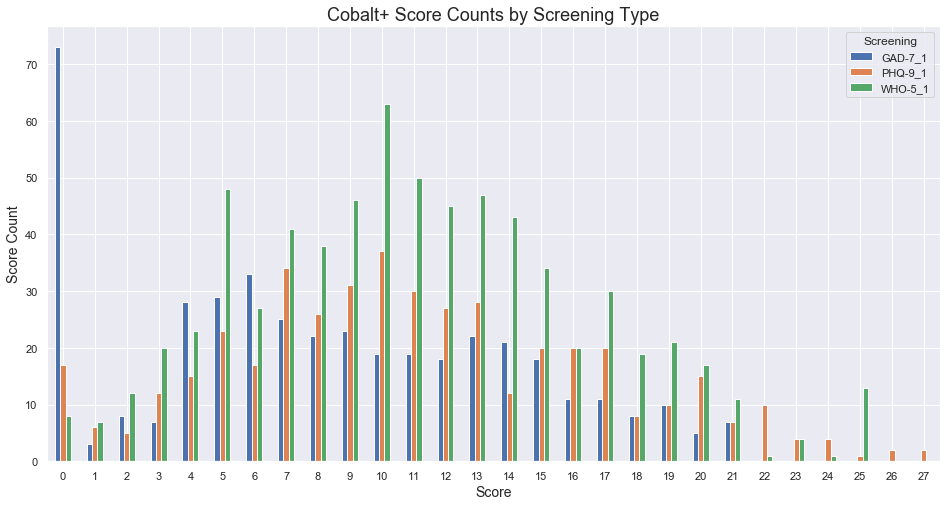

In [53]:
xticks = np.arange(len(screening_plot_data))
xticklabels = set(sorted(screening_plot_data.index.to_list()))
ax = screening_plot_data.plot(figsize=(16,8), kind='bar')

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=0)

ax.set_xlabel('Score', fontsize=14)
ax.set_ylabel('Score Count', fontsize=14)
ax.set_title('Cobalt+ Score Counts by Screening Type', fontsize=18)

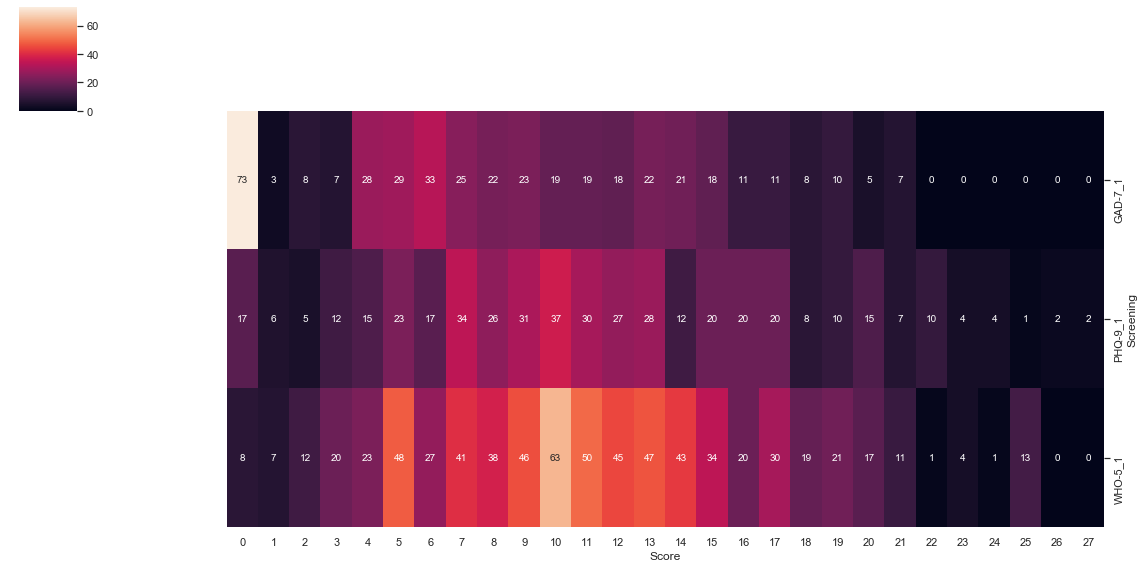

In [54]:
sns.clustermap(screening_plot_data.transpose(),row_cluster=False, col_cluster=False, annot=True, figsize=(16,8))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



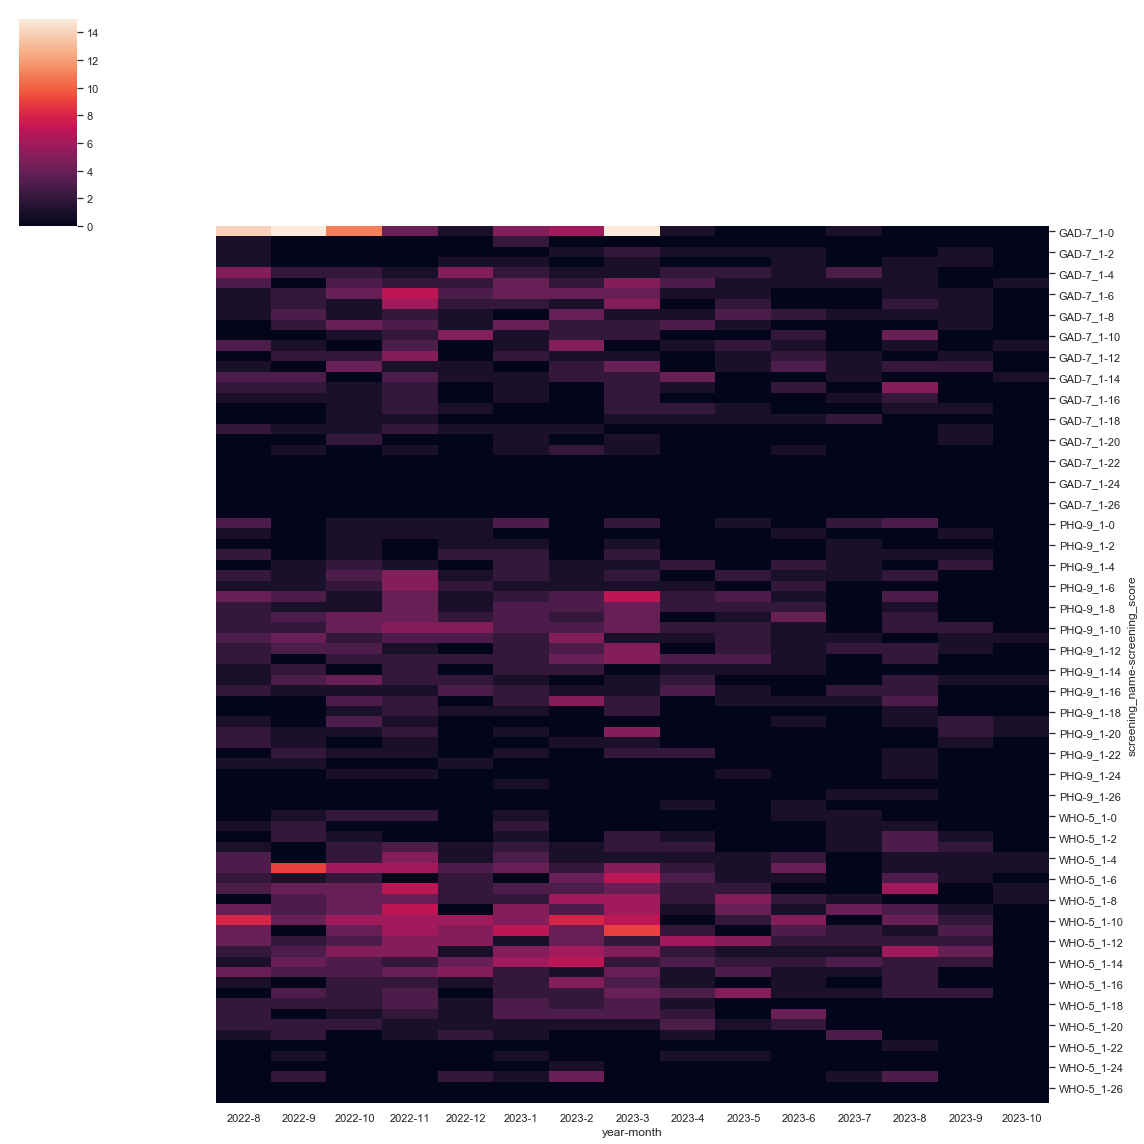

In [55]:
screening_data_temp = screening_data_master.groupby(['created','screening_name','screening_score'])[['screening_session_screening_id']].count().unstack(level=1).droplevel(axis=1, level=0).fillna(0).unstack(level=1).fillna(0)
screening_data_temp['year'] = screening_data_temp.index.year
screening_data_temp['month'] = screening_data_temp.index.month
screening_data_temp['day'] = screening_data_temp.index.day
screening_data_temp['dayofweek'] = screening_data_temp.index.dayofweek

usecols = screening_data_temp.columns[:-4]
screening_data_temp = screening_data_temp.set_index(['year','month'])[usecols].sum(axis=0, level=[0,1]).transpose()
sns.clustermap(screening_data_temp, row_cluster=False, col_cluster=False,figsize=(16,16))

#### Plotting: Cobalt+ Users

In [56]:
screen_target = screening_data_master.merge(study_acct[['account_id','arm']], 
                                            how='inner', 
                                            left_on='target_account_id', 
                                            right_on='account_id', 
                                            indicator='id_source')

screen_target_plot_data = screen_target.groupby(['screening_name','screening_score'])[['screening_session_screening_id']].count()
screen_target_plot_data = screen_target_plot_data.unstack().fillna(0).transpose()
screen_target_plot_data = screen_target_plot_data.droplevel(axis=0,level=0)

screen_target_plot_data.index = screen_target_plot_data.index.rename('Score')
screen_target_plot_data.columns = screen_target_plot_data.columns.rename('Screening')

In [57]:
print('Total Participants:',screen_target_plot_data['WHO-5_1'].sum())
print('Unique Scores:',len(screen_target_plot_data))
print('Unique Screenings',len(screen_target_plot_data.columns))
screen_target_plot_data.head()

Total Participants: 43.0
Unique Scores: 21
Unique Screenings 3


Screening,GAD-7_1,PHQ-9_1,WHO-5_1
Score,,,
0,6.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,2.0,4.0,4.0


Text(0.5, 1.0, 'Native Cobalt+ Score Counts: WHO-5')

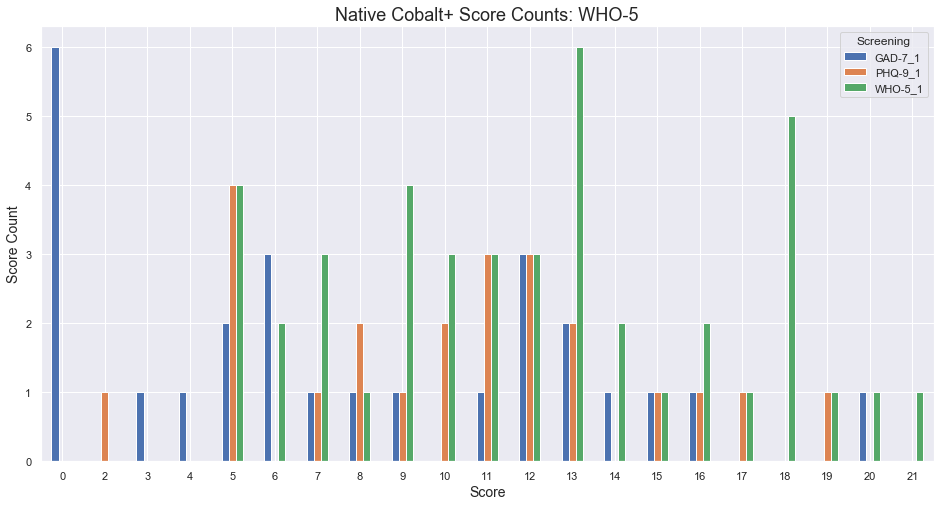

In [58]:
xticks = np.arange(len(screen_target_plot_data))
xticklabels = set(sorted(screen_target_plot_data.index.to_list()))
ax = screen_target_plot_data.plot(figsize=(16,8), kind='bar')

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=0)

ax.set_xlabel('Score', fontsize=14)
ax.set_ylabel('Score Count', fontsize=14)
ax.set_title('Native Cobalt+ Score Counts: WHO-5', fontsize=18)

#### Plotting: Cobalt+ Users by Arm 

In [59]:
screen_target_arm_data = screen_target.groupby(['screening_name','screening_score','arm'])[['screening_session_screening_id']].count()
screen_target_arm_data = screen_target_arm_data.unstack(level=[0,2]).fillna(0)

screen_target_arm_data = screen_target_arm_data.droplevel(axis=1,level=0)
screen_target_arm_data.index = screen_target_arm_data.index.rename('Score')
screen_target_arm_data.columns = screen_target_arm_data.columns.rename(['Screening','Arm'])

In [60]:
print('Total Control Participants:',screen_target_arm_data[('WHO-5_1','Control')].sum())
print('Total Intervention Participants:',screen_target_arm_data[('WHO-5_1','Intervention')].sum())
print('Unique Scores:',len(screen_target_arm_data))
print('Unique Screenings',len(screen_target_arm_data.columns))
screen_target_arm_data.head()

Total Control Participants: 25.0
Total Intervention Participants: 18.0
Unique Scores: 21
Unique Screenings 6


Screening GAD-7_1                   PHQ-9_1         WHO-5_1             
Arm       Control Intervention Intervention Control Control Intervention
Score                                                                   
0             2.0          4.0          0.0     0.0     0.0          0.0
2             0.0          0.0          1.0     0.0     0.0          0.0
3             0.0          1.0          0.0     0.0     0.0          0.0
4             0.0          1.0          0.0     0.0     0.0          0.0
5             1.0          1.0          3.0     1.0     1.0          3.0

Text(0.5, 1.0, 'Native Cobalt+ Score Counts by Control and Intervention: WHO-5')

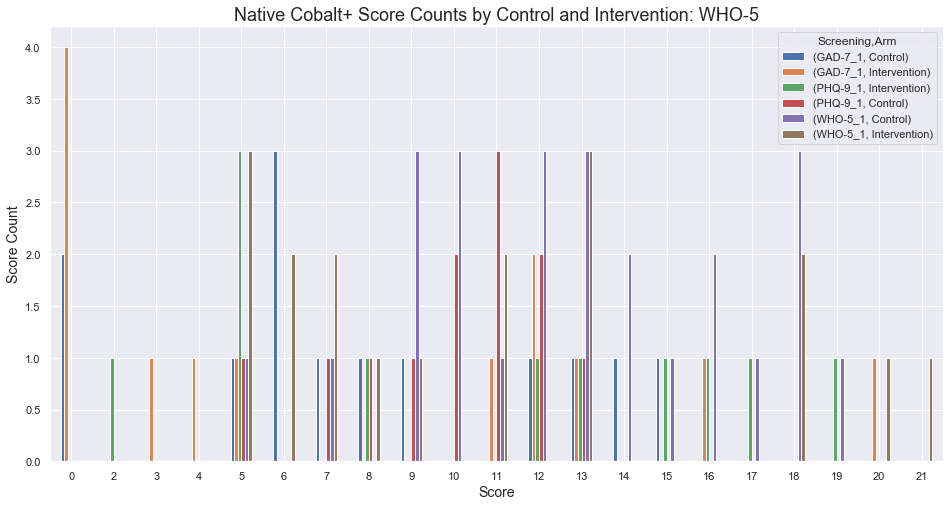

In [61]:
xticks = np.arange(len(screen_target_arm_data))
xticklabels = set(sorted(screen_target_arm_data.index.to_list()))
ax = screen_target_arm_data.plot(figsize=(16,8), kind='bar')

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=0)

ax.set_xlabel('Score', fontsize=14)
ax.set_ylabel('Score Count', fontsize=14)
ax.set_title('Native Cobalt+ Score Counts by Control and Intervention: WHO-5', fontsize=18)

# Data Analysis

## Summary Stats

### Accounts

#### Account Source

In [62]:
# All acounts
study_acct_src_summary = pd.concat([study_acct['account_source_id'].value_counts(0),
                                    study_acct['account_source_id'].value_counts(1)],axis=1)
study_acct_src_summary.columns = ['count','pct']
study_acct_src_summary

,count,pct
PENN_SSO,392,0.4906
PENN_KEY_SSO,226,0.2829
ANONYMOUS,181,0.2265


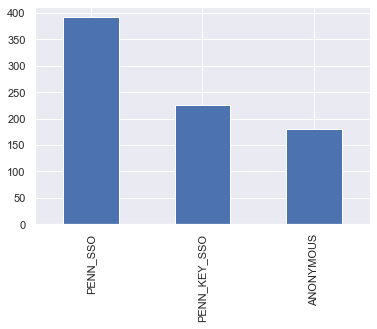

In [63]:
ax = study_acct_src_summary['count'].plot(kind='bar')

In [64]:
# Accounts with appointments
study_appt_acct_src_summary = pd.concat([study_appt_acct['account_source_id'].value_counts(0),
                                        study_appt_acct['account_source_id'].value_counts(1)],axis=1)
study_appt_acct_src_summary.columns = ['count','pct']
study_appt_acct_src_summary

,count,pct
PENN_KEY_SSO,99,0.5440
PENN_SSO,52,0.2857
ANONYMOUS,31,0.1703


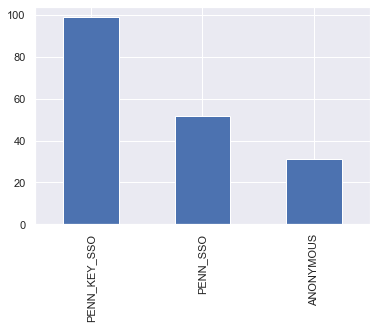

In [65]:
ax = study_appt_acct_src_summary['count'].plot(kind='bar')

### Appointments

#### Appointment Account Source

In [66]:
# All appointments
study_appt_src_summary = pd.concat([study_appt['account_source_id'].value_counts(0),
                                    study_appt['account_source_id'].value_counts(1)],axis=1)
study_appt_src_summary.columns = ['count','pct']
study_appt_src_summary

,count,pct
PENN_KEY_SSO,162,0.5294
PENN_SSO,101,0.3301
ANONYMOUS,43,0.1405


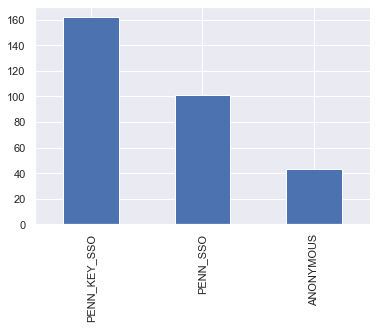

In [67]:
ax = study_appt_src_summary['count'].plot(kind='bar')

#### Provider Support Role

In [68]:
study_appt_06_role_summary = pd.concat([study_appt_06['support_role_id'].value_counts(0),
                                    study_appt_06['support_role_id'].value_counts(1)],axis=1)
study_appt_06_role_summary.columns = ['count','pct']
study_appt_06_role_summary

,count,pct
COACH,54,0.4219
CLINICIAN,44,0.3438
CARE_MANAGER,30,0.2344


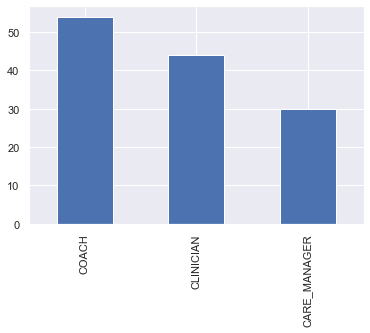

In [69]:
ax = study_appt_06_role_summary['count'].plot(kind='bar')

#### Apppintment Type

In [70]:
study_appt_06['title'].value_counts()

1:1 Session with Resilience Coach       51
1:1 with Care Manager                   47
1:1 Appointment with Psychotherapist    27
Coaching Visit                           2
1:1 Strength and Training Specialist     1
Name: title, dtype: int64

In [71]:
study_appt_06['appointment_type_name'].value_counts()

1:1 Session with Resilience Coach       51
1:1 with Care Manager                   47
1:1 Appointment with Psychotherapist    27
Coaching Visit                           2
1:1 Strength and Training Specialist     1
Name: appointment_type_name, dtype: int64

#### Participant Appointments

In [72]:
study_part_appt_count = study_appt_06.groupby(['participant_id'])['appointment_id'].count().sort_values(ascending=False)
study_acct_appt_count = study_appt_06.groupby(['account_id'])['appointment_id'].count().sort_values(ascending=False)
study_partAcct_appt_count = study_appt_06.groupby(['participant_id','account_id'])['appointment_id'].count().sort_values(ascending=False)

Text(0.5, 1.0, 'Participant Appointment Counts: Histogram')

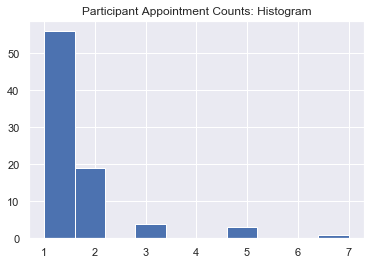

In [73]:
ax = study_part_appt_count.hist(bins=10)
ax.set_title('Participant Appointment Counts: Histogram')

Text(0.5, 1.0, 'Participant Appointment Counts: Cumulative Sum')

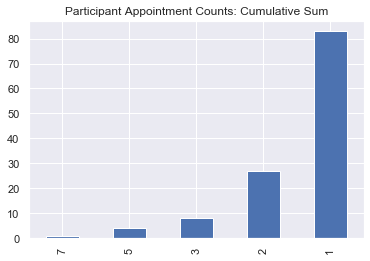

In [74]:
ax = study_part_appt_count.value_counts().sort_index(ascending=False).cumsum().plot(kind='bar')
ax.set_title('Participant Appointment Counts: Cumulative Sum')

Text(0.5, 0.98, 'Histogram of Participant Appointments by Study Arm')

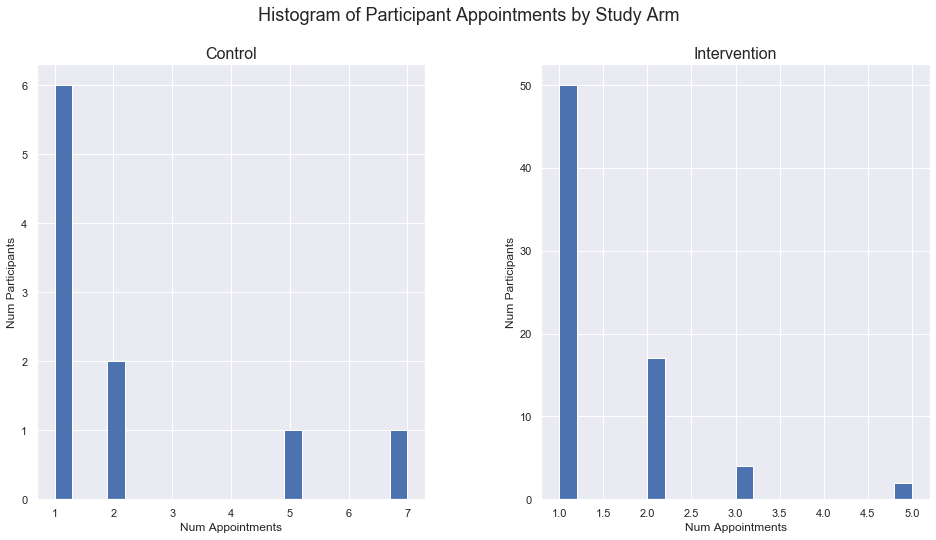

In [411]:
plot_data = study_appt_06.groupby(['participant_id','arm'])['appointment_id'].count().sort_values(ascending=False).unstack()
ax = plot_data.hist(figsize=(16,8),bins=20)
ax[0][0].set_xlabel('Num Appointments')
ax[0][0].set_ylabel('Num Participants')
ax[0][0].set_title('Control', fontsize=16)

ax[0][1].set_xlabel('Num Appointments')
ax[0][1].set_ylabel('Num Participants')
ax[0][1].set_title('Intervention', fontsize=16)

plt.suptitle('Histogram of Participant Appointments by Study Arm', fontsize=18)

In [413]:
plot_data.sum()

arm
Control          22.0
Intervention    106.0
dtype: float64

## Time Series

### Appointments

In [76]:
study_appt.head(2)

,appointment_id,provider_id,account_id,acuity_appointment_id,acuity_appointment_type_id,acuity_class_id,bluejeans_meeting_id,videoconference_url,title,start_time,end_time,duration_in_minutes,time_zone,canceled,canceled_at,created,last_updated,epic_contact_id,epic_contact_id_type,appointment_type_id,phone_number,videoconference_platform_id,appointment_reason_id,created_by_account_id,comment,attendance_status_id,bluejeans_participant_passcode,intake_assessment_id,scheduling_system_id,canceled_for_reschedule,rescheduled_appointment_id,intake_account_session_id,interaction_instance_id,patient_reminder_scheduled_message_id,patient_order_id,epic_appointment_fhir_id,created_year,created_month,created_day,created_year_month,created_year_month_week,created_dayofyear,apt_year,apt_month,apt_day,apt_year_month,apt_year_month_week,apt_dayofyear,created_completed_time,appointment_type_name,support_role_id,account_source_id,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,unique_email
0,98365dba-f07b-4e89-b4aa-2eca8d37e428,c236acc5-9473-457a-af51-de57bddcb8a3,90c9b318-a1be-4b67-b5fb-a7a68559e0e3,8.4849e+08,NaN,NaN,1.0494e+08,https://bluejeans.com/698184757/7722,1:1 Appointment with Psychotherapist,2022-07-06 16:00:00-04:00,2022-07-06 17:00:00,60,America/New_York,False,NaT,2022-06-22 16:25:35.721374-04:00,2022-06-22 20:25:35.721374+00:00,None,None,2294b4f1-7fad-454f-a118-06b479356d7d,None,BLUEJEANS,3c34a096-2f4d-4091-a9d8-f0381ba079a1,90c9b318-a1be-4b67-b5fb-a7a68559e0e3,None,UNKNOWN,7722,5929588e-ee53-4df5-9c62-1656a43ff4cd,ACUITY,False,None,b762db93-d3fd-4933-a856-c56126db5a37,None,None,None,None,2022,6,22,2022-06-01,2022-06-16,20220622,2022,7,6,2022-07-01,2022-06-30,20220706,14.0,1:1 Appointment with Psychotherapist,CLINICIAN,PENN_KEY_SSO,1000772287,Intervention,2022-04-14 00:00:00-04:00,2022-10-14 00:00:00-04:00,2023-01-14 00:00:00-05:00,cartj,cartj,jennifer.carter1@pennmedicine.upenn.edu,shortyjmb82@yahoo.com,shortyjmb82@yahoo.com
1,1cf6c04c-7692-4252-aa2b-10efd8815950,c236acc5-9473-457a-af51-de57bddcb8a3,c3256070-e04c-4b11-a1b6-3de08e57d9a6,8.9845e+08,NaN,NaN,1.0763e+08,https://bluejeans.com/515071484/4323,1:1 Appointment with Psychotherapist,2022-09-21 16:00:00-04:00,2022-09-21 17:00:00,60,America/New_York,False,NaT,2022-09-15 17:10:08.807789-04:00,2022-09-15 21:10:08.807789+00:00,None,None,2294b4f1-7fad-454f-a118-06b479356d7d,None,BLUEJEANS,3c34a096-2f4d-4091-a9d8-f0381ba079a1,c3256070-e04c-4b11-a1b6-3de08e57d9a6,None,UNKNOWN,4323,5929588e-ee53-4df5-9c62-1656a43ff4cd,ACUITY,False,None,78babe22-e422-476a-96fe-50ad7be01531,None,None,None,None,2022,9,15,2022-09-01,2022-09-15,20220915,2022,9,21,2022-09-01,2022-09-15,20220921,6.0,1:1 Appointment with Psychotherapist,CLINICIAN,PENN_SSO,1000769261,Control,2022-04-07 00:00:00-04:00,2022-10-07 00:00:00-04:00,2023-01-07 00:00:00-05:00,lehof,lehof,leah.coghlan@pennmedicine.upenn.edu,lehoffman87@gmail.com,leah.coghlan@pennmedicine.upenn.edu


In [77]:
# Time series data
study_appt_ts_data = pd.DataFrame(study_appt.groupby(['apt_year','apt_month']).count().appointment_id)
study_appt_ts_data.index.names = ['year','month']
study_appt_weekly_ts_data = pd.DataFrame(study_appt.groupby(['apt_year_month_week']).count().appointment_id)
study_appt_weekly_ts_data.index = pd.MultiIndex.from_arrays([study_appt_weekly_ts_data.index.year, 
                                                      study_appt_weekly_ts_data.index.month, 
                                                      study_appt_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])
study_appt_weekly_ts_data = study_appt_weekly_ts_data.merge(week_index_df, how='outer', left_index=True, right_index=True)# Get missing index values
study_appt_weekly_ts_data = study_appt_weekly_ts_data.fillna(0)

study_appt_completed_ts_data = pd.DataFrame(study_appt_completed.groupby(['apt_year','apt_month']).count().appointment_id)
study_appt_completed_ts_data.index.names = ['year','month']
study_appt_weekly_completed_ts_data = pd.DataFrame(study_appt_completed.groupby(['apt_year_month_week']).count().appointment_id)
study_appt_weekly_completed_ts_data.index = pd.MultiIndex.from_arrays([study_appt_weekly_completed_ts_data.index.year, 
                                                                study_appt_weekly_completed_ts_data.index.month, 
                                                                study_appt_weekly_completed_ts_data.index.day],
                                                                names=['Year','Month','Week'])
study_appt_weekly_completed_ts_data = study_appt_weekly_completed_ts_data.merge(week_index_df, how='outer', left_index=True, right_index=True)# Get missing index values
study_appt_weekly_completed_ts_data = study_appt_weekly_completed_ts_data.fillna(0)

study_appt_canceled_ts_data = pd.DataFrame(study_appt_canceled.groupby(['apt_year','apt_month']).count().appointment_id)
study_appt_canceled_ts_data.index.names = ['year','month']
study_appt_weekly_canceled_ts_data = pd.DataFrame(study_appt_canceled.groupby(['apt_year_month_week']).count().appointment_id)
study_appt_weekly_canceled_ts_data.index = pd.MultiIndex.from_arrays([study_appt_weekly_canceled_ts_data.index.year, 
                                                                study_appt_weekly_canceled_ts_data.index.month, 
                                                                study_appt_weekly_canceled_ts_data.index.day],
                                                                names=['Year','Month','Week'])
study_appt_weekly_canceled_ts_data = study_appt_weekly_canceled_ts_data.merge(week_index_df, how='outer', left_index=True, right_index=True)# Get missing index values
study_appt_weekly_canceled_ts_data = study_appt_weekly_canceled_ts_data.fillna(0)

# Time series data by provider role
study_apptRole_ts_data = pd.DataFrame(study_appt.groupby(['apt_year','apt_month','support_role_id']).count().appointment_id)
study_apptRole_ts_data = study_apptRole_ts_data.unstack().fillna(0).appointment_id
study_apptRole_ts_data.index.names = ['year','month']

study_apptRole_weekly_ts_data = pd.DataFrame(study_appt.groupby(['apt_year_month_week', 'support_role_id']).count()).appointment_id
study_apptRole_weekly_ts_data = study_apptRole_weekly_ts_data.unstack().fillna(0)
study_apptRole_weekly_ts_data.index = pd.MultiIndex.from_arrays([study_apptRole_weekly_ts_data.index.year, 
                                                      study_apptRole_weekly_ts_data.index.month, 
                                                      study_apptRole_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])
study_apptRole_weekly_ts_data = study_apptRole_weekly_ts_data.merge(week_index_df, how='outer', left_index=True, right_index=True)# Get missing index values
study_apptRole_weekly_ts_data = study_apptRole_weekly_ts_data.fillna(0)

# Time series data by account source
study_apptSrc_ts_data = pd.DataFrame(study_appt.groupby(['apt_year','apt_month','account_source_id']).count().appointment_id)
study_apptSrc_ts_data = study_apptSrc_ts_data.unstack().fillna(0).appointment_id
study_apptSrc_ts_data.index.names = ['year','month']

study_apptSrc_weekly_ts_data = pd.DataFrame(study_appt.groupby(['apt_year_month_week', 'account_source_id']).count()).appointment_id
study_apptSrc_weekly_ts_data = study_apptSrc_weekly_ts_data.unstack().fillna(0)
study_apptSrc_weekly_ts_data.index = pd.MultiIndex.from_arrays([study_apptSrc_weekly_ts_data.index.year, 
                                                      study_apptSrc_weekly_ts_data.index.month, 
                                                      study_apptSrc_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])
study_apptSrc_weekly_ts_data = study_apptSrc_weekly_ts_data.merge(week_index_df, how='outer', left_index=True, right_index=True)# Get missing index values
study_apptSrc_weekly_ts_data = study_apptSrc_weekly_ts_data.fillna(0)

# Time series data by study arm
study_apptArm_ts_data = pd.DataFrame(study_appt.groupby(['apt_year','apt_month','arm']).count().appointment_id)
study_apptArm_ts_data = study_apptArm_ts_data.unstack().fillna(0).appointment_id
study_apptArm_ts_data.index.names = ['year','month']

study_apptArm_weekly_ts_data = pd.DataFrame(study_appt.groupby(['apt_year_month_week', 'arm']).count()).appointment_id
study_apptArm_weekly_ts_data = study_apptArm_weekly_ts_data.unstack().fillna(0)
study_apptArm_weekly_ts_data.index = pd.MultiIndex.from_arrays([study_apptArm_weekly_ts_data.index.year, 
                                                      study_apptArm_weekly_ts_data.index.month, 
                                                      study_apptArm_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])
study_apptArm_weekly_ts_data = study_apptArm_weekly_ts_data.merge(week_index_df, how='outer', left_index=True, right_index=True)# Get missing index values
study_apptArm_weekly_ts_data = study_apptArm_weekly_ts_data.fillna(0)

In [78]:
pd.DataFrame(study_appt_06.groupby(['apt_year_month_week', 'arm', 'support_role_id']).count()).appointment_id.unstack().fillna(0).sum(axis=0,level=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



support_role_id,CARE_MANAGER,CLINICIAN,COACH
arm,,,
Control,3.0,15.0,4.0
Intervention,27.0,29.0,50.0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



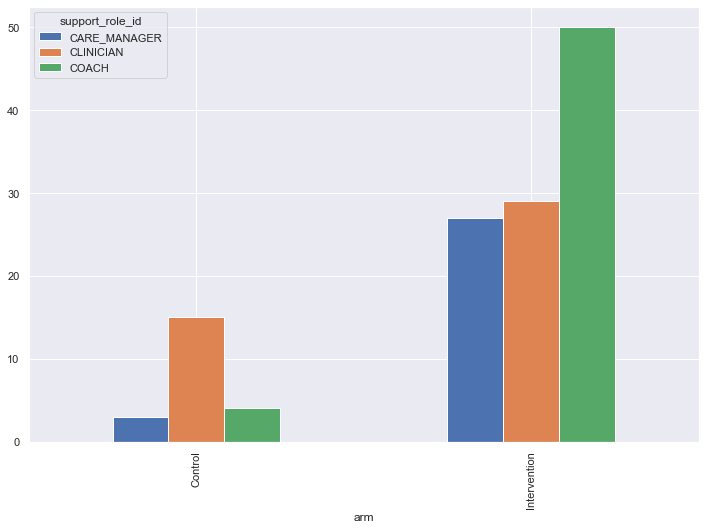

In [79]:
pd.DataFrame(study_appt_06.groupby(['apt_year_month_week', 'arm', 'support_role_id']).count()).appointment_id.unstack().fillna(0).sum(axis=0,level=1).plot(figsize=(12,8),kind='bar')

In [80]:
# Compare study appt counts to all appt counts for same time interval
# At height, study appts accounts for over 40% of all cobalt appts!
study_appt_baseline = study_appt_weekly_ts_data.merge(apt_weekly_ts_data, how='left', left_index=True, right_index=True)
study_appt_baseline = study_appt_baseline.rename(columns={'appointment_id_x':'study_appts', 'appointment_id_y':'all_appts'})
study_appt_baseline['study_appts_pct'] = (study_appt_baseline['study_appts']/study_appt_baseline['all_appts'])*100
study_appt_baseline.head(2)

study_appts  all_appts  study_appts_pct
Year Month Week                                         
2020 4     9             0.0          4           0.0000
           16            2.0         24           8.3333

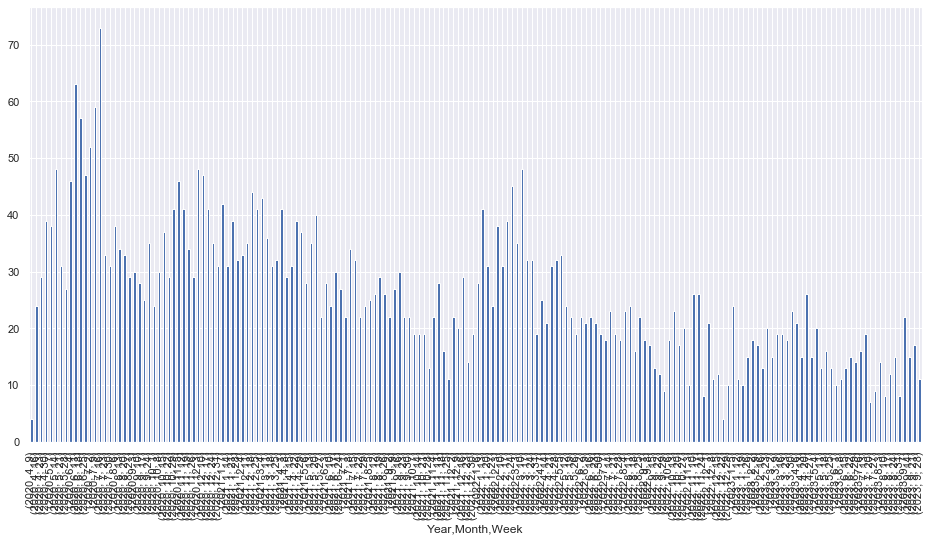

In [81]:
# all cobalt appts
study_appt_baseline['all_appts'].plot(figsize=(16,8),kind='bar')

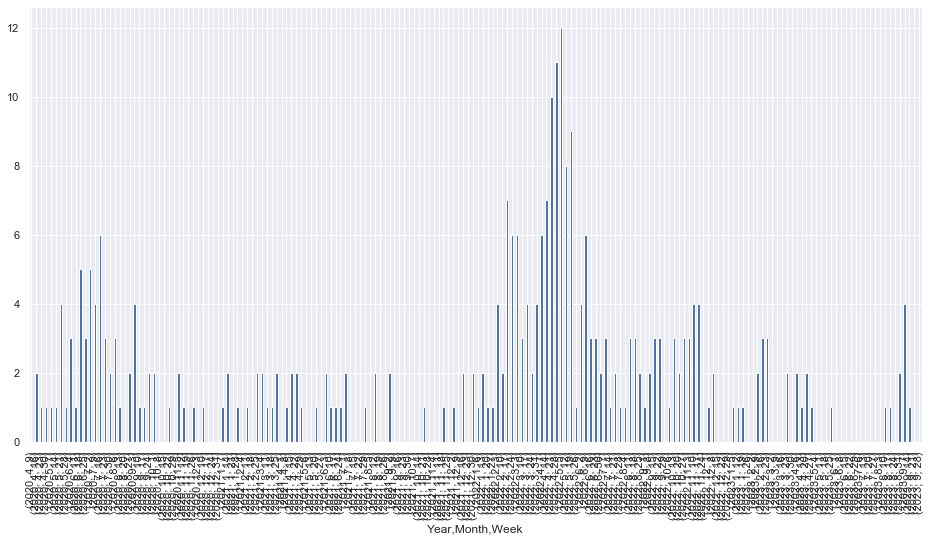

In [82]:
# all study appts
study_appt_baseline['study_appts'].plot(figsize=(16,8),kind='bar')

Mean: 6.747
Median: 4.257
Std. Dev.: 8.343
Min: 0.0
Max: 40.909


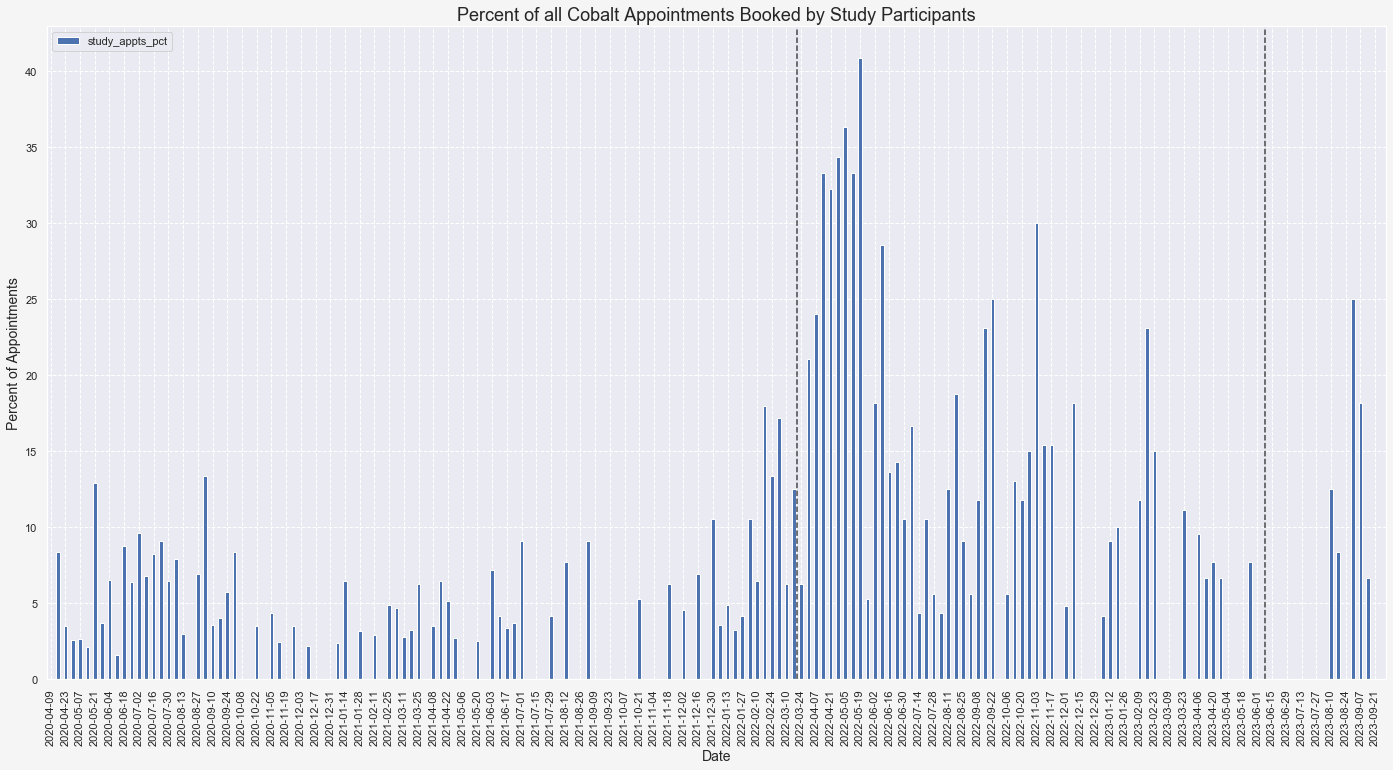

In [83]:
# pct of all cobalt appts by all study participants
print('Mean:',round(study_appt_baseline['study_appts_pct'].mean(),3))
print('Median:',round(study_appt_baseline['study_appts_pct'].median(),3))
print('Std. Dev.:',round(study_appt_baseline['study_appts_pct'].std(),3))
print('Min:',round(study_appt_baseline['study_appts_pct'].min(),3))
print('Max:',round(study_appt_baseline['study_appts_pct'].max(),3))

xlabels = get_ts_xlabels(index=study_appt_baseline.index, time='weekly')
fig, ax = plt.subplots(figsize=(24,12), facecolor='whitesmoke')
plt.grid(True, linestyle='--')
study_appt_baseline['study_appts_pct'].plot(ax=ax, kind='bar')
ax.set_title('Percent of all Cobalt Appointments Booked by Study Participants', fontsize=18)
ax.set_xlabel('Date',fontsize=14)
ax.set_xticks(np.arange(0,len(study_appt_baseline),2))
ax.set_xticklabels(xlabels[::2], rotation=90)
ax.set_ylabel('Percent of Appointments',fontsize=14)

ax.legend([study_appt_baseline.columns[-1]])

ax.axvline(len(xlabels)/2+10.5, color='black', ls='--', alpha=0.7)
ax.axvline(len(xlabels)-17, color='black', ls='--', alpha=0.7)

In [84]:
# MIGHT work for appts and text EVENTS - needs to be corrected heavily for group and content(links) creation dates
#### MAKE A MONTH AND/OR A WEEK INDEX TO USE AS UNIVERSAL STARTING POINT (I.E. "DAYS FROM ENROLLMENT")
#### CAN ANALYZE ALL PARTICIPANTS IN THEIR MONTH/WEEK 1, 2, 3, ETC. (APPTS, GROUPS, CONTENT, TEXTS/LINKS)
#### SEASONALITY, AND OTHER PARTICIPANT [SUB]GROUPINGS WILL NEED TO BE CONSIDERED CAREFULLY

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



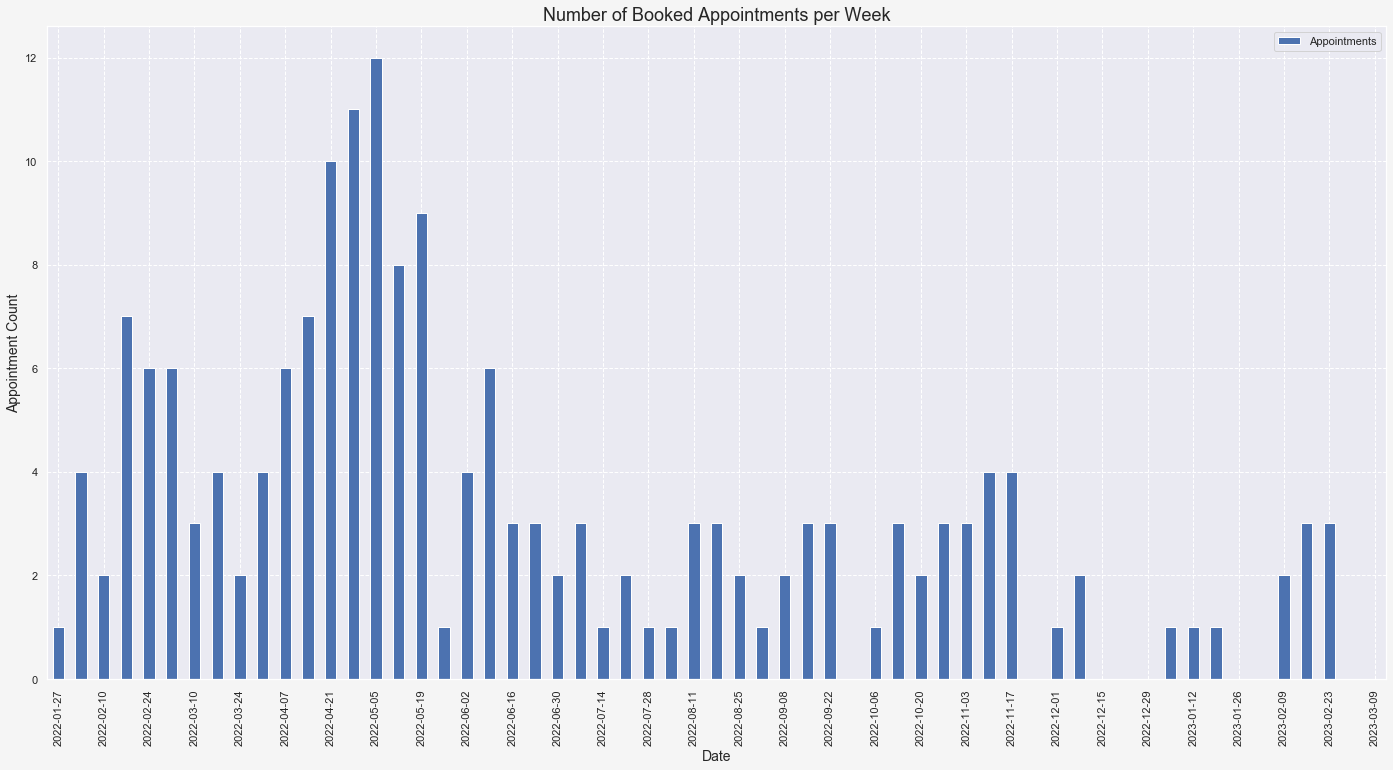

In [199]:
# Plot
plot_data = study_appt_weekly_ts_data.loc[(2022,1,27):(2023,3,9)]
xlabels = get_ts_xlabels(index=plot_data.index, time='weekly')
fig, ax = plt.subplots(figsize=(24,12), facecolor='whitesmoke')
plt.grid(True, linestyle='--')
plot_data.plot(ax=ax, kind='bar', stacked=True)
ax.set_title('Number of Booked Appointments per Week', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_xticks(np.arange(0,len(plot_data),2))
ax.set_xticklabels(xlabels[::2], rotation=90)
ax.set_ylabel('Appointment Count', fontsize=14)
#ax.set_xlim(0,len(plot_data)-4)
#ax.set_ylim(0,APT_WEEKLY_YMAX)

ax.legend(plot_data.columns, labels=['Appointments'])

#ax.axvline(len(xlabels)/2+10.5, color='black', ls='--', alpha=0.7)
#ax.axvline(len(xlabels)-17, color='black', ls='--', alpha=0.7)

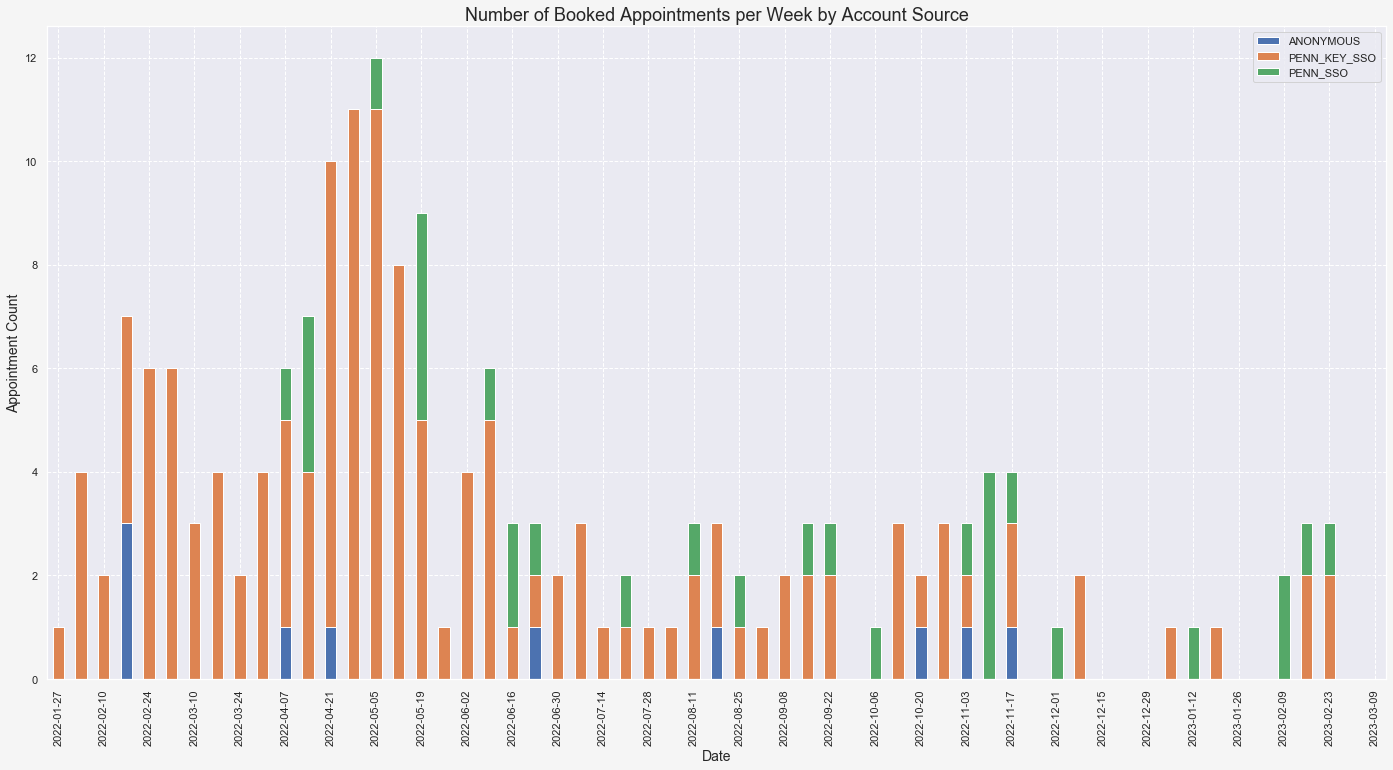

In [203]:
# Plot
plot_data = study_apptSrc_weekly_ts_data.loc[(2022,1,27):(2023,3,9)]
xlabels = get_ts_xlabels(index=plot_data.index, time='weekly')
fig, ax = plt.subplots(figsize=(24,12), facecolor='whitesmoke')
plt.grid(True, linestyle='--')
plot_data.plot(ax=ax, kind='bar', stacked=True)
ax.set_title('Number of Booked Appointments per Week by Account Source', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_xticks(np.arange(0,len(plot_data),2))
ax.set_xticklabels(xlabels[::2], rotation=90)
ax.set_ylabel('Appointment Count', fontsize=14)
#ax.set_xlim(0,len(plot_data)-4)
#ax.set_ylim(0,APT_WEEKLY_YMAX)

ax.legend(plot_data.columns)

#ax.axvline(len(xlabels)/2+10.5, color='black', ls='--', alpha=0.7)
#ax.axvline(len(xlabels)-17, color='black', ls='--', alpha=0.7)

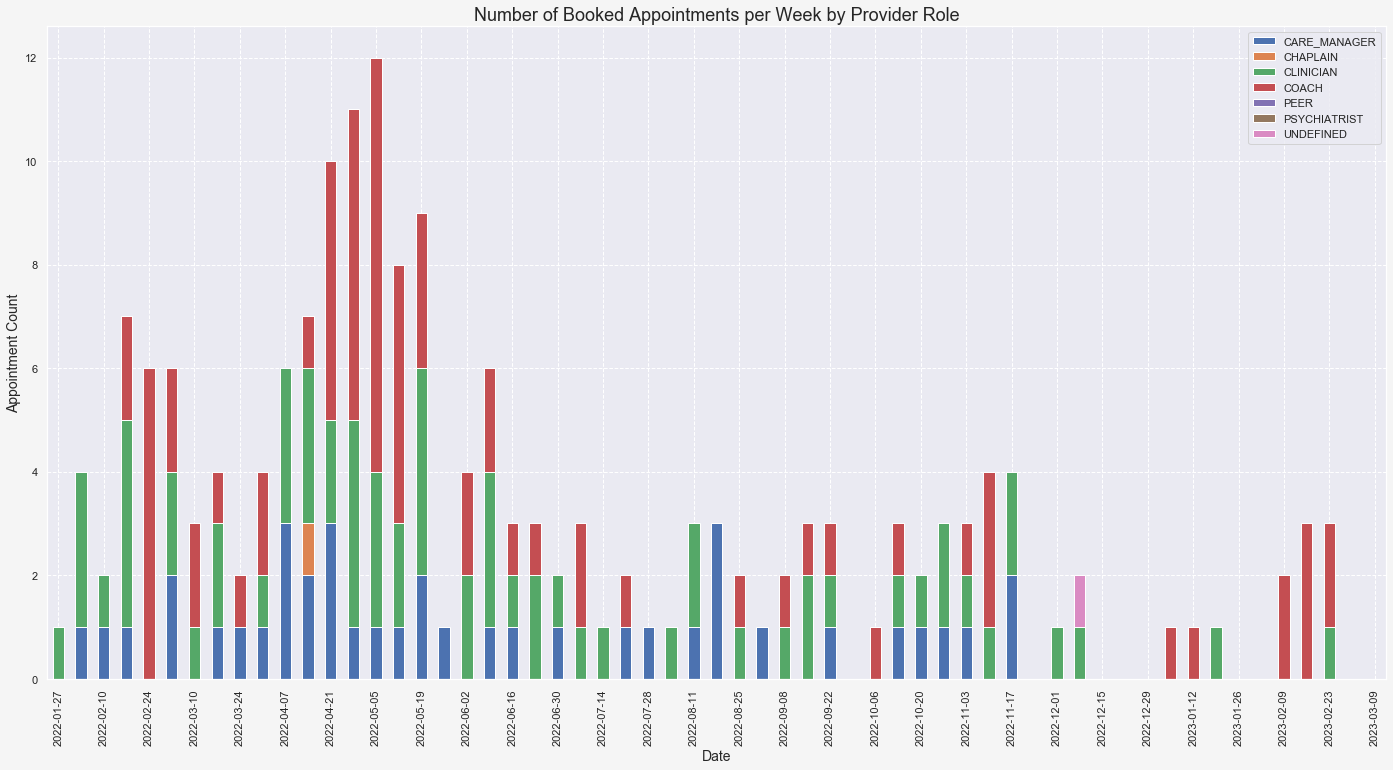

In [204]:
# Plot
plot_data = study_apptRole_weekly_ts_data.loc[(2022,1,27):(2023,3,9)]
xlabels = get_ts_xlabels(index=plot_data.index, time='weekly')
fig, ax = plt.subplots(figsize=(24,12), facecolor='whitesmoke')
plt.grid(True, linestyle='--')
plot_data.plot(ax=ax, kind='bar', stacked=True)
ax.set_title('Number of Booked Appointments per Week by Provider Role', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_xticks(np.arange(0,len(plot_data),2))
ax.set_xticklabels(xlabels[::2], rotation=90)
ax.set_ylabel('Appointment Count', fontsize=14)
#ax.set_xlim(0,len(plot_data)-4)
#ax.set_ylim(0,APT_WEEKLY_YMAX)

ax.legend(plot_data.columns)

#ax.axvline(len(xlabels)/2+10.5, color='black', ls='--', alpha=0.7)
#ax.axvline(len(xlabels)-17, color='black', ls='--', alpha=0.7)

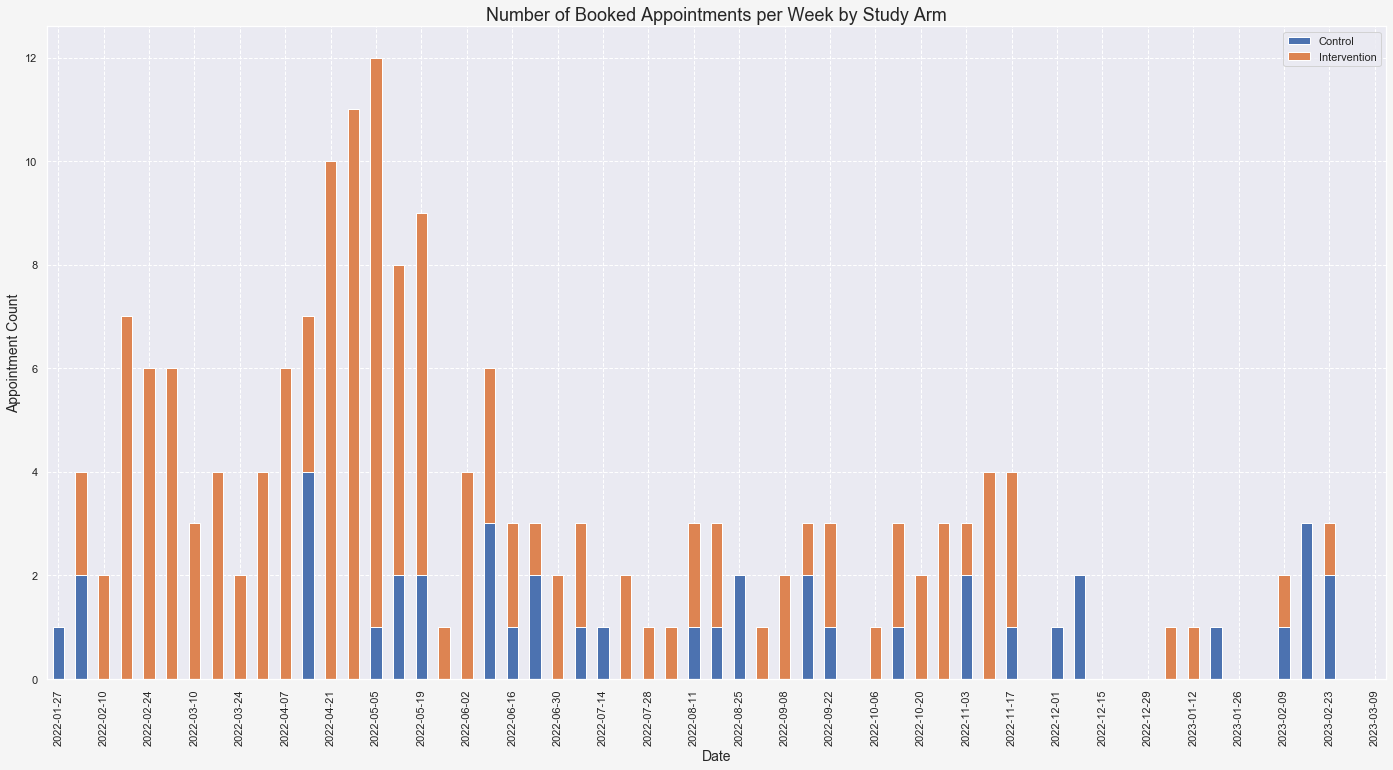

In [205]:
# Plot
plot_data = study_apptArm_weekly_ts_data.loc[(2022,1,27):(2023,3,9)]
xlabels = get_ts_xlabels(index=plot_data.index, time='weekly')
fig, ax = plt.subplots(figsize=(24,12), facecolor='whitesmoke')
plt.grid(True, linestyle='--')
plot_data.plot(ax=ax, kind='bar', stacked=True)
ax.set_title('Number of Booked Appointments per Week by Study Arm', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_xticks(np.arange(0,len(plot_data),2))
ax.set_xticklabels(xlabels[::2], rotation=90)
ax.set_ylabel('Appointment Count', fontsize=14)
#ax.set_xlim(0,len(plot_data)-4)
#ax.set_ylim(0,APT_WEEKLY_YMAX)

ax.legend(plot_data.columns)

#ax.axvline(len(xlabels)/2+10.5, color='black', ls='--', alpha=0.7)
#ax.axvline(len(xlabels)-17, color='black', ls='--', alpha=0.7)

In [89]:
days_from_start = (study_appt_06['start_time'] - study_appt_06['start_date']).dt.ceil('d')

bins = []
start=1
delta=7
end = days_from_start.max()//pd.Timedelta(delta,'d') + 2

for x in range(start,end*delta,delta):
    bins.append(pd.Timedelta(x,'d'))

bin_output = pd.cut(days_from_start, bins=bins, right=False, include_lowest=True, retbins=True)

In [90]:
plot_data = pd.concat([study_appt_06,days_from_start,bin_output[0]],axis=1)
plot_data = plot_data.rename(columns={0:'days_from_start',1:'bin_range'})
plot_data['bin_left'] = plot_data['bin_range'].apply(lambda x: x.left).copy()
plot_data['bin_right'] = plot_data['bin_range'].apply(lambda x: x.right).copy()

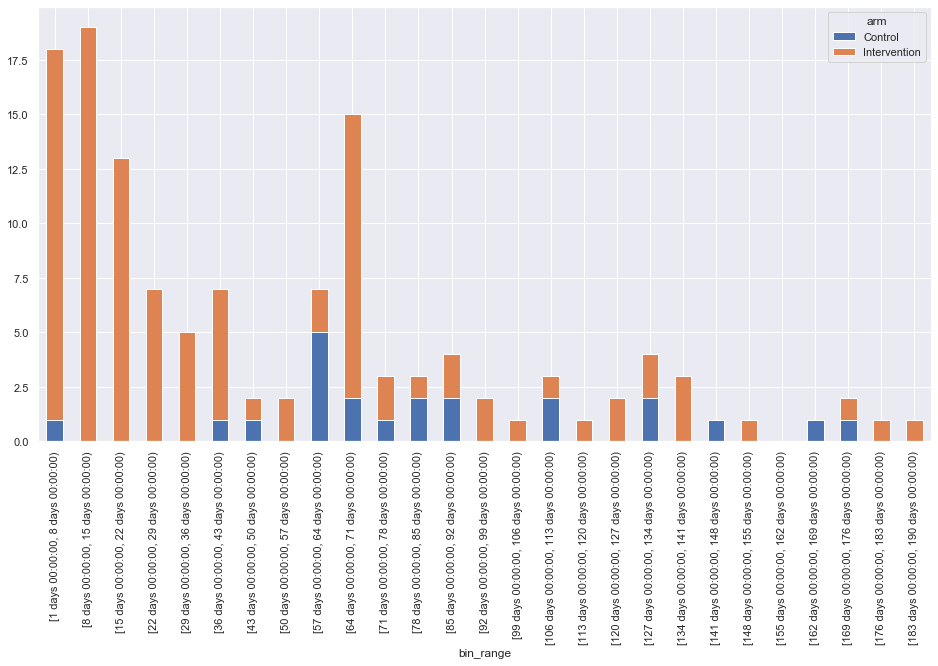

In [91]:
plot_data.groupby(['bin_range','arm'])[['appointment_id']].count().unstack().droplevel(axis=1,level=0).plot(figsize=(16,8),kind='bar',stacked=True)

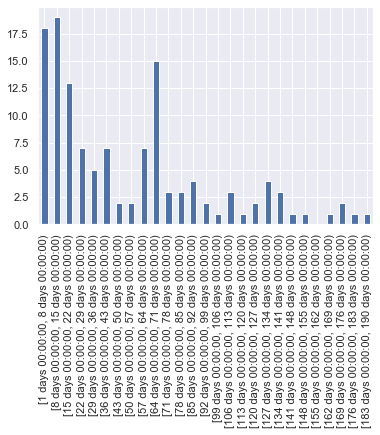

In [92]:
bin_output[0].value_counts().sort_index().plot(kind='bar')

In [93]:
intervention_v2 = pd.read_csv(COBALT_PLUS_DATA_PATH +'allintervention-v2.csv', dtype={'Participant':'str'})
intervention_v2 = intervention_v2.dropna(how='all')
print(len(intervention_v2))
print(len(intervention_v2.columns))
print(len(intervention_v2.Participant.unique()))
intervention_v2.head(2)

1891
26
642


,Participant,Arm,enrollment_start_date,Notification,timestamp,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,GAD7_1,GAD7_2,GAD7_3,GAD7_4,GAD7_5,GAD7_6,GAD7_7,phq9_value,gad7_value,Unnamed: 23,survey,missing data - did they receive an appt recommendation
0,1000728614,Intervention,1/31/22 16:52,SMS,1/31/22 17:11,0,0,0,1,0,1,1,0,0,1,1,1,0,0,1,0,3.0,4.0,NaN,baseline,NaN
1,1000730208,Intervention,2/3/22 13:33,SMS,2/3/22 13:37,0,0,1,2,0,0,0,0,0,1,0,1,1,0,1,0,3.0,4.0,NaN,baseline,NaN


In [94]:
intervention_v2_has_appt = enrollment[(enrollment['participant_id'].isin(intervention_v2['Participant'].unique())) & 
                                     (enrollment['has_appt_06']==1)]
intervention_v2_has_appt_summary = intervention_v2_has_appt.iloc[:,9:].sum()

In [95]:
print(len(intervention_v2_has_appt))
print(len(intervention_v2_has_appt.columns))
intervention_v2_has_appt.head(2)

73
21


,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,num_appt_06,num_appt_06_completed,num_appt_06_canceled,has_appt_06,has_appt_06_completed,num_appt_69,num_appt_69_completed,num_appt_69_canceled,has_appt_69,has_appt_69_completed,num_acct,has_acct
0,1000728614,Intervention,2022-01-31 00:00:00-05:00,2022-07-31 00:00:00-04:00,2022-10-31 00:00:00-04:00,rasch,rasch,rachelle.schneider@pennmedicine.upenn.edu,rasch@alumni.upenn.edu,3.0,3.0,0.0,1,1,0.0,0.0,0.0,0,0,3.0,1.0
36,1000731479,Intervention,2022-02-07 00:00:00-05:00,2022-08-07 00:00:00-04:00,2022-11-07 00:00:00-05:00,doshihe,doshihe,hersh.doshi@pennmedicine.upenn.edu,hershajaydoshi@gmail.com,1.0,1.0,0.0,1,1,0.0,0.0,0.0,0,0,2.0,1.0


In [96]:
intervention_v2_has_appt_summary

num_appt_06              106.0
num_appt_06_completed     82.0
num_appt_06_canceled      24.0
has_appt_06               73.0
has_appt_06_completed     64.0
num_appt_69               11.0
num_appt_69_completed      8.0
num_appt_69_canceled       3.0
has_appt_69                7.0
has_appt_69_completed      7.0
num_acct                 127.0
has_acct                  73.0
dtype: float64

In [97]:
save_name = COBALT_PLUS_DATA_PATH + 'intervention_v2_has_appt_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
intervention_v2_has_appt.to_csv(save_name)

In [98]:
save_name = COBALT_PLUS_DATA_PATH + 'intervention_v2_has_appt_summary_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
intervention_v2_has_appt_summary.to_csv(save_name)

In [99]:
intervention_v2_no_appt = enrollment[(enrollment['participant_id'].isin(intervention_v2['Participant'].unique())) & 
                                     (enrollment['has_appt_06']==0)]
intervention_v2_no_appt_summary = intervention_v2_no_appt.iloc[:,9:].sum()

In [100]:
print(len(intervention_v2_no_appt))
print(len(intervention_v2_no_appt.columns))
intervention_v2_no_appt.head(2)

568
21


,participant_id,arm,start_date,6_months,9_months,pennkey,pennkey_confirmed,primary_email,secondary_email,num_appt_06,num_appt_06_completed,num_appt_06_canceled,has_appt_06,has_appt_06_completed,num_appt_69,num_appt_69_completed,num_appt_69_canceled,has_appt_69,has_appt_69_completed,num_acct,has_acct
2,1000730208,Intervention,2022-02-03 00:00:00-05:00,2022-08-03 00:00:00-04:00,2022-11-03 00:00:00-04:00,garvin,garvin,eugenia.south@pennmedicine.upenn.edu,e.c.garvin@gmail.com,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0,2.0,1.0
4,1000730770,Intervention,2022-02-04 00:00:00-05:00,2022-08-04 00:00:00-04:00,2022-11-04 00:00:00-04:00,bradenk,bradenk,keenabr@pennmedicine.upenn.edu,bradenk@nursing.upenn.edu,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0


In [101]:
intervention_v2_no_appt_summary

num_appt_06                0.0
num_appt_06_completed      0.0
num_appt_06_canceled       0.0
has_appt_06                0.0
has_appt_06_completed      0.0
num_appt_69                5.0
num_appt_69_completed      4.0
num_appt_69_canceled       1.0
has_appt_69                5.0
has_appt_69_completed      4.0
num_acct                 325.0
has_acct                 225.0
dtype: float64

In [102]:
save_name = COBALT_PLUS_DATA_PATH + 'intervention_v2_no_appt_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
intervention_v2_no_appt.to_csv(save_name)

In [103]:
save_name = COBALT_PLUS_DATA_PATH + 'intervention_v2_no_appt_summary_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
intervention_v2_no_appt_summary.to_csv(save_name)

# Bitly Links

## Process Files

In [104]:
file_paths = []
file_names = []
raw_data = []
file_id = 0
record_id = 0
for file_path in glob.glob(BITLY_DATA_PATH + '*.csv'):
    file_name = file_path.split('/')[-1]
    date_range_start = file_name.split('_')[-3]
    date_range_end = '-'.join(file_name.split('_')[-1].split('-')[0:3])
    
    file_data = pd.read_csv(file_path)
    file_data['date_range_start'] = date_range_start
    file_data['date_range_end'] = date_range_end
    
    record_id_col_loc = 0
    record_id_col_name = 'record_id'
    record_id_col_values = ['rid'+str(record_id).zfill(4) for record_id in range(record_id,record_id+len(file_data))]
    file_data.insert(loc=record_id_col_loc, column=record_id_col_name, value=record_id_col_values)
    
    file_id_col_loc = 1
    file_id_col_name = 'file_id'
    file_id_col_values = 'fid'+str(file_id).zfill(4)
    file_data.insert(loc=file_id_col_loc, column=file_id_col_name, value=file_id_col_values)
    
    file_paths.append(file_path)
    file_names.append(file_name)
    raw_data.append(file_data)
    file_id += 1
    record_id += len(file_data)

In [105]:
print(sum([len(item) for item in raw_data]), 'rows')
print(len(raw_data[0].columns), 'columns')
print(len(raw_data), 'files')

653 rows
12 columns
51 files


## Build Master Data

In [106]:
# Raw bitly data
bitly_data = pd.concat(raw_data)

# Adjust column formatting
bitly_data.columns = bitly_data.columns.str.strip()
bitly_data.columns = bitly_data.columns.str.lower()
bitly_data.columns = bitly_data.columns.str.replace(' ','_')

# Adjust column data types
time_cols = ['date_created','date_range_start','date_range_end']
for col in time_cols:
    bitly_data[col] = pd.to_datetime(bitly_data[col])
    
# Add relevant columns
bitly_data['created_start'] = bitly_data['date_range_start'] - bitly_data['date_created']
bitly_data['created_end'] = bitly_data['date_range_end'] - bitly_data['date_created']
bitly_data['start_end'] = bitly_data['date_range_end'] - bitly_data['date_range_start']

# Sort by created date
bitly_data = bitly_data.reset_index(drop=True)

In [107]:
print(len(bitly_data), 'rows')
print(len(bitly_data.columns), 'columns')
bitly_data.head(5)

653 rows
15 columns


,record_id,file_id,bitlink,custom_bitlink,date_created,title,long_url,clicks_for_all_time,clicks_for_date_range,status,date_range_start,date_range_end,created_start,created_end,start_end
0,rid0000,fid0000,https://penncobaltplus.com/3vLl4Ax,https://penncobaltplus.com/ClinCardFAQ,2022-05-05,Box,https://upenn.box.com/s/mxlafo5echcubp30ru8kam...,224,7,NaN,2023-01-17,2023-01-23,257 days,263 days,6 days
1,rid0001,fid0000,http://penncobaltplus.com/34eQu6Y,http://penncobaltplus.com/connect-with-peer,2022-01-28,Cobalt,https://www.penncobalt.com/connect-with-suppor...,563,2,NaN,2023-01-17,2023-01-23,354 days,360 days,6 days
2,rid0002,fid0001,https://penncobaltplus.com/35r1wGN,https://penncobaltplus.com/survey,2022-01-28,NaN,https://redcap.link/cobaltRCT?utm_source=redca...,712,340,NaN,2022-03-11,2022-05-09,42 days,101 days,59 days
3,rid0003,fid0001,http://penncobaltplus.com/34eQu6Y,http://penncobaltplus.com/connect-with-peer,2022-01-28,Cobalt,https://www.penncobalt.com/connect-with-suppor...,251,158,NaN,2022-03-11,2022-05-09,42 days,101 days,59 days
4,rid0004,fid0001,http://penncobaltplus.com/32J7q5g,http://penncobaltplus.com/connect-with-support,2022-01-28,Cobalt,https://www.penncobalt.com/connect-with-suppor...,110,69,NaN,2022-03-11,2022-05-09,42 days,101 days,59 days


In [108]:
for col in bitly_data.columns:
    print('Col:', col, 'Unique Values:', len(bitly_data[col].unique()))

Col: record_id Unique Values: 653
Col: file_id Unique Values: 51
Col: bitlink Unique Values: 43
Col: custom_bitlink Unique Values: 13
Col: date_created Unique Values: 16
Col: title Unique Values: 6
Col: long_url Unique Values: 42
Col: clicks_for_all_time Unique Values: 226
Col: clicks_for_date_range Unique Values: 124
Col: status Unique Values: 1
Col: date_range_start Unique Values: 50
Col: date_range_end Unique Values: 50
Col: created_start Unique Values: 163
Col: created_end Unique Values: 157
Col: start_end Unique Values: 9


## Get Link Data

### Bitlinks - Intermittent Click Counts

In [109]:
bitlink_dict = dict()
bitlink_top_dict = dict()
for idx,group in bitly_data.groupby(['bitlink']):
    group = group.sort_values(['date_range_end'])
    bitlink_dict[idx] = group
    bitlink_top_dict[idx] = group.tail(1)
    
bitlink_click_data = pd.concat((bitlink_dict))
bitlink_top_cick_data = pd.concat((bitlink_top_dict))

In [110]:
print(len(bitlink_click_data))
print(len(bitlink_click_data.columns))
bitlink_click_data.head(2)

653
15


record_id  file_id  \
http://penncobaltplus.com/32J7q5g 292   rid0292  fid0022   
                                  258   rid0258  fid0019   

                                                                 bitlink  \
http://penncobaltplus.com/32J7q5g 292  http://penncobaltplus.com/32J7q5g   
                                  258  http://penncobaltplus.com/32J7q5g   

                                                                       custom_bitlink  \
http://penncobaltplus.com/32J7q5g 292  http://penncobaltplus.com/connect-with-support   
                                  258  http://penncobaltplus.com/connect-with-support   

                                      date_created   title  \
http://penncobaltplus.com/32J7q5g 292   2022-01-28  Cobalt   
                                  258   2022-01-28  Cobalt   

                                                                                long_url  \
http://penncobaltplus.com/32J7q5g 292  https://www.penncobalt.com/connect-with-suppor...   
                                  258  https://www.penncobalt.com/connect-with-suppor...   

                                       clicks_for_all_time  \
http://penncobaltplus.com/32J7q5g 292                   19   
                                  258                   25   

                                       clicks_for_date_range  status  \
http://penncobaltplus.com/32J7q5g 292                     19     NaN   
                                  258                     25     NaN   

                                      date_range_start date_range_end  \
http://penncobaltplus.com/32J7q5g 292       2021-12-31     2022-02-28   
                                  258       2022-01-07     2022-03-07   

                                      created_start created_end start_end  
http://penncobaltplus.com/32J7q5g 292      -28 days     31 days   59 days  
                                  258      -21 days     38 days   59 days

In [111]:
print(len(bitlink_top_cick_data))
print(len(bitlink_top_cick_data.columns))
bitlink_top_cick_data.head(2)

43
15


,,record_id,file_id,bitlink,custom_bitlink,date_created,title,long_url,clicks_for_all_time,clicks_for_date_range,status,date_range_start,date_range_end,created_start,created_end,start_end
http://penncobaltplus.com/32J7q5g,543,rid0543,fid0043,http://penncobaltplus.com/32J7q5g,http://penncobaltplus.com/connect-with-support,2022-01-28,Cobalt,https://www.penncobalt.com/connect-with-suppor...,204,1,NaN,2023-01-01,2023-01-09,338 days,346 days,8 days
http://penncobaltplus.com/34eQu6Y,117,rid0117,fid0009,http://penncobaltplus.com/34eQu6Y,http://penncobaltplus.com/connect-with-peer,2022-01-28,Cobalt,https://www.penncobalt.com/connect-with-suppor...,566,2,NaN,2023-02-13,2023-02-20,381 days,388 days,7 days


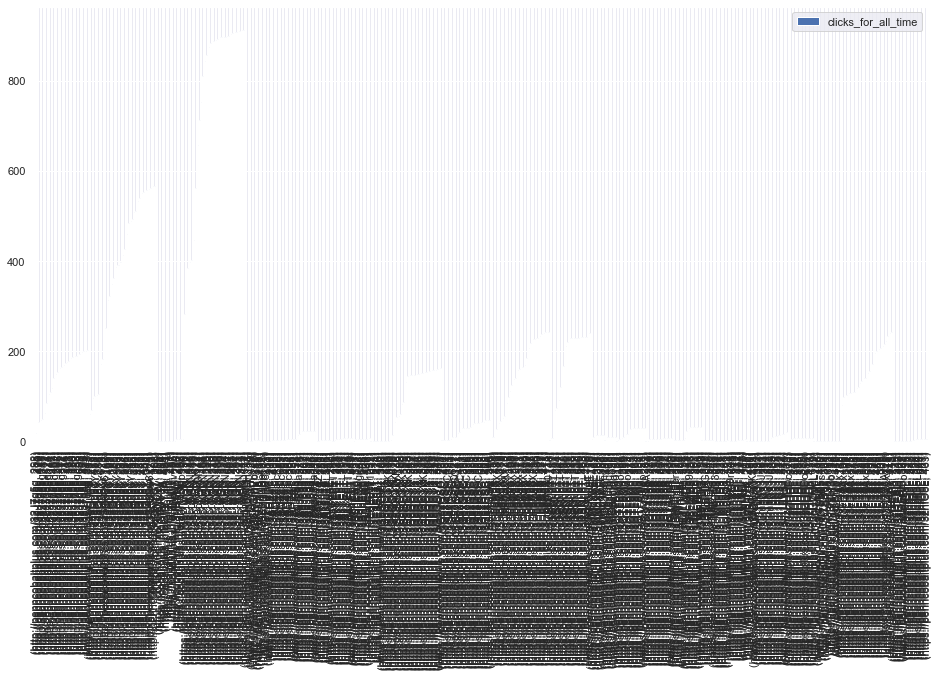

In [112]:
bitlink_click_data[['clicks_for_all_time']].plot(figsize=(16,8),kind='bar')

In [113]:
# Save data
save_name = COBALT_PLUS_DATA_PATH + 'bitly_click_data_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
bitlink_click_data.to_csv(save_name)

### Bitlinks - Top Four Highest Recorded Clicks

In [114]:
usecols = ['title','long_url','date_created','date_range_start','date_range_end','created_start','created_end','start_end','clicks_for_all_time']
bitly_data_top4 = bitlink_click_data.droplevel(axis=0,level=1)[usecols]
bitly_data_top4 = bitly_data_top4.sort_values(['clicks_for_all_time']).groupby(axis=0,level=0).tail(4)

In [115]:
print(len(bitly_data_top4))
print(len(bitly_data_top4.columns))
bitly_data_top4.head()

156
9


,title,long_url,date_created,date_range_start,date_range_end,created_start,created_end,start_end,clicks_for_all_time
https://penncobaltplus.com/3rser3o,Qualtrics Survey | Qualtrics Experience Manage...,https://upenn.co1.qualtrics.com/jfe/form/SV_cC...,2022-04-15,2022-02-22,2022-04-22,-52 days,7 days,59 days,1
https://penncobaltplus.com/3r7SB5s,PennKey Recovery Service,https://challengeresponse.apps.upenn.edu/chall...,2022-01-28,2022-05-03,2022-06-09,95 days,132 days,37 days,1
https://penncobaltplus.com/3r7SB5s,PennKey Recovery Service,https://challengeresponse.apps.upenn.edu/chall...,2022-01-28,2022-04-05,2022-06-03,67 days,126 days,59 days,1
https://penncobaltplus.com/3r7SB5s,PennKey Recovery Service,https://challengeresponse.apps.upenn.edu/chall...,2022-01-28,2022-05-08,2022-05-23,100 days,115 days,15 days,1
https://penncobaltplus.com/36HoWsH,Cobalt,https://www.penncobalt.com/on-your-time/c74c24...,2022-04-01,2022-03-18,2022-05-16,-14 days,45 days,59 days,1


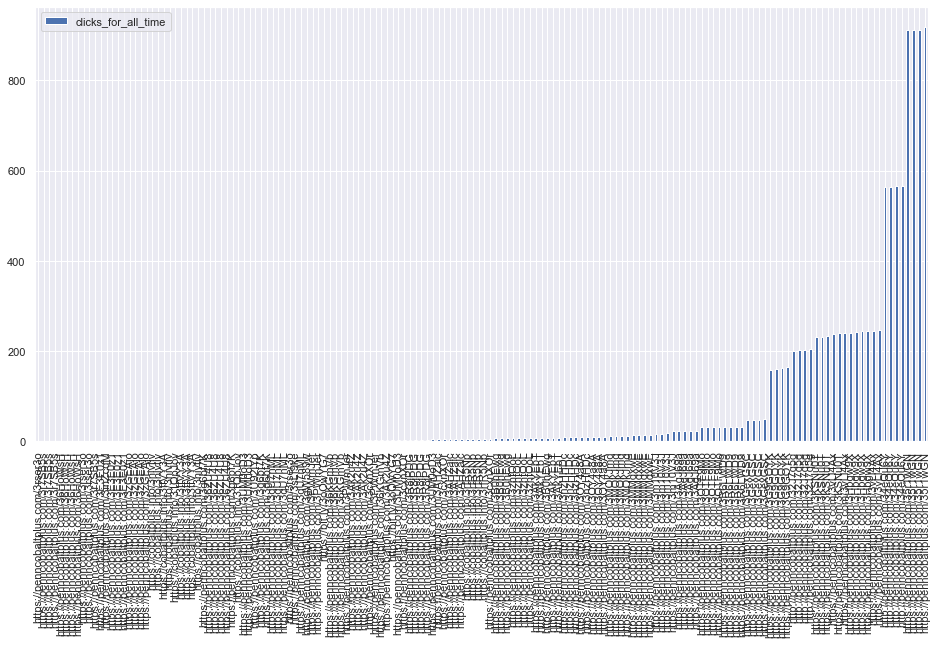

In [116]:
bitly_data_top4[['clicks_for_all_time']].plot(figsize=(16,8),kind='bar')

In [117]:
# Save data
save_name = COBALT_PLUS_DATA_PATH + 'bitly_click_data_top4_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
bitly_data_top4.to_csv(save_name)

### Bitlinks - Total Clicks for All Time

In [118]:
usecols = ['title','long_url','date_created','date_range_start','date_range_end','created_start','created_end','start_end','clicks_for_all_time']
bitly_data_top = bitlink_top_cick_data.droplevel(axis=0,level=1)[usecols]
bitly_data_top = bitly_data_top.sort_values(['clicks_for_all_time']).groupby(axis=0,level=0).tail(1)

In [119]:
print(len(bitly_data_top))
print(len(bitly_data_top.columns))
bitly_data_top.head()

43
9


,title,long_url,date_created,date_range_start,date_range_end,created_start,created_end,start_end,clicks_for_all_time
https://penncobaltplus.com/3inZcqM,Cobalt,https://www.penncobalt.com/on-your-time/bdf7f7...,2022-11-28,2022-11-28,2022-12-05,0 days,7 days,7 days,1
https://penncobaltplus.com/3E3E0z1,Cobalt,https://www.penncobalt.com/on-your-time/e8fc41...,2022-09-30,2022-09-30,2022-11-28,0 days,59 days,59 days,1
https://penncobaltplus.com/3r7SB5s,PennKey Recovery Service,https://challengeresponse.apps.upenn.edu/chall...,2022-01-28,2022-05-20,2022-07-18,112 days,171 days,59 days,1
https://penncobaltplus.com/3zGEAjo,Cobalt,https://www.penncobalt.com/on-your-time/f7a6f5...,2022-07-29,2022-08-12,2022-10-10,14 days,73 days,59 days,1
https://penncobaltplus.com/36HoWsH,Cobalt,https://www.penncobalt.com/on-your-time/c74c24...,2022-04-01,2022-04-05,2022-06-03,4 days,63 days,59 days,1


Text(0.5, 1.0, 'Total Clicks Per Link')

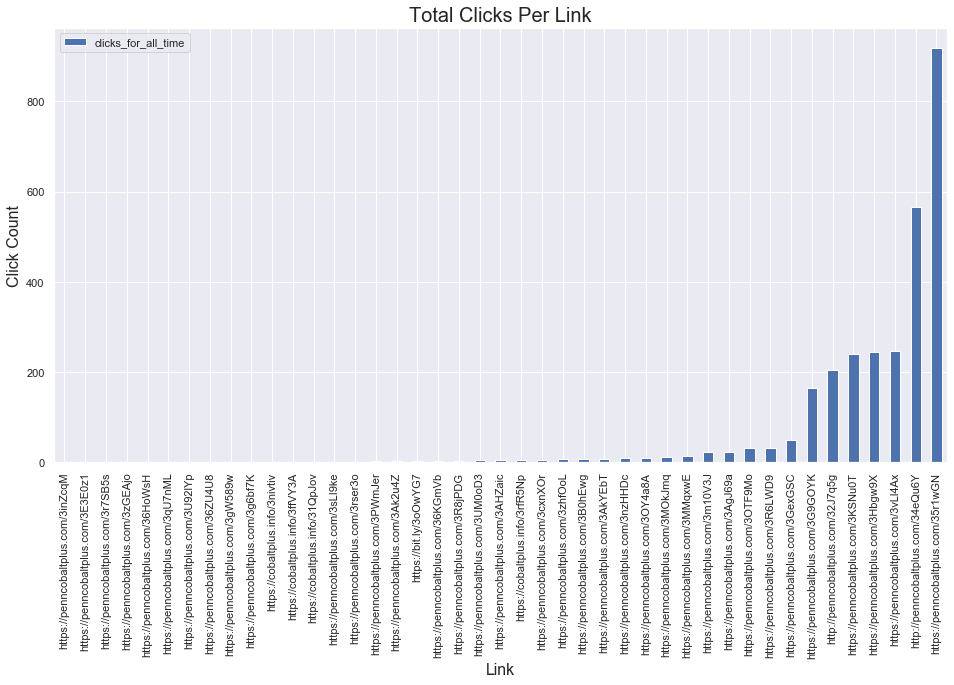

In [120]:
ax = bitly_data_top[['clicks_for_all_time']].plot(figsize=(16,8), kind='bar')
ax.set_xlabel('Link', fontsize=16)
ax.set_ylabel('Click Count', fontsize=16)
ax.set_title('Total Clicks Per Link', fontsize=20)

In [121]:
# Save data
save_name = COBALT_PLUS_DATA_PATH + 'bitly_click_data_top_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
bitly_data_top.to_csv(save_name)

In [122]:
temp_services = [item[3] for item in  bitly_data_top['long_url'].str.split('/')]
temp_services[7] = 'form'
temp_services[11] = 'connect-with-support'
temp_services[12] = 'connect-with-support'
temp_services[14] = 'form'
temp_services[17] = 'connect-with-support'
temp_services[22] = 'redcap_screening'
temp_services[35] = 'connect-with-support'
temp_services[37] = 'connect-with-support'
temp_services[38] = 'in-the-studio'
temp_services[39] = 'homepage'
temp_services[40] = 'search'
temp_services[41] = 'connect-with-support'
temp_services[42] = 'redcap_screening'

In [123]:
temp_data = bitly_data_top[['clicks_for_all_time']].copy()
temp_data['services'] = temp_services
temp_data.reset_index()

,index,clicks_for_all_time,services
0,https://penncobaltplus.com/3inZcqM,1,on-your-time
1,https://penncobaltplus.com/3E3E0z1,1,on-your-time
2,https://penncobaltplus.com/3r7SB5s,1,challengeResponse
3,https://penncobaltplus.com/3zGEAjo,1,on-your-time
4,https://penncobaltplus.com/36HoWsH,1,on-your-time
5,https://penncobaltplus.com/3qU7nML,2,on-your-time
6,https://penncobaltplus.com/3U92lYp,2,on-your-time
7,https://penncobaltplus.com/36ZU4U8,2,form
8,https://penncobaltplus.com/3gW589w,2,on-your-time
9,https://penncobaltplus.com/3g6bf7K,2,on-your-time


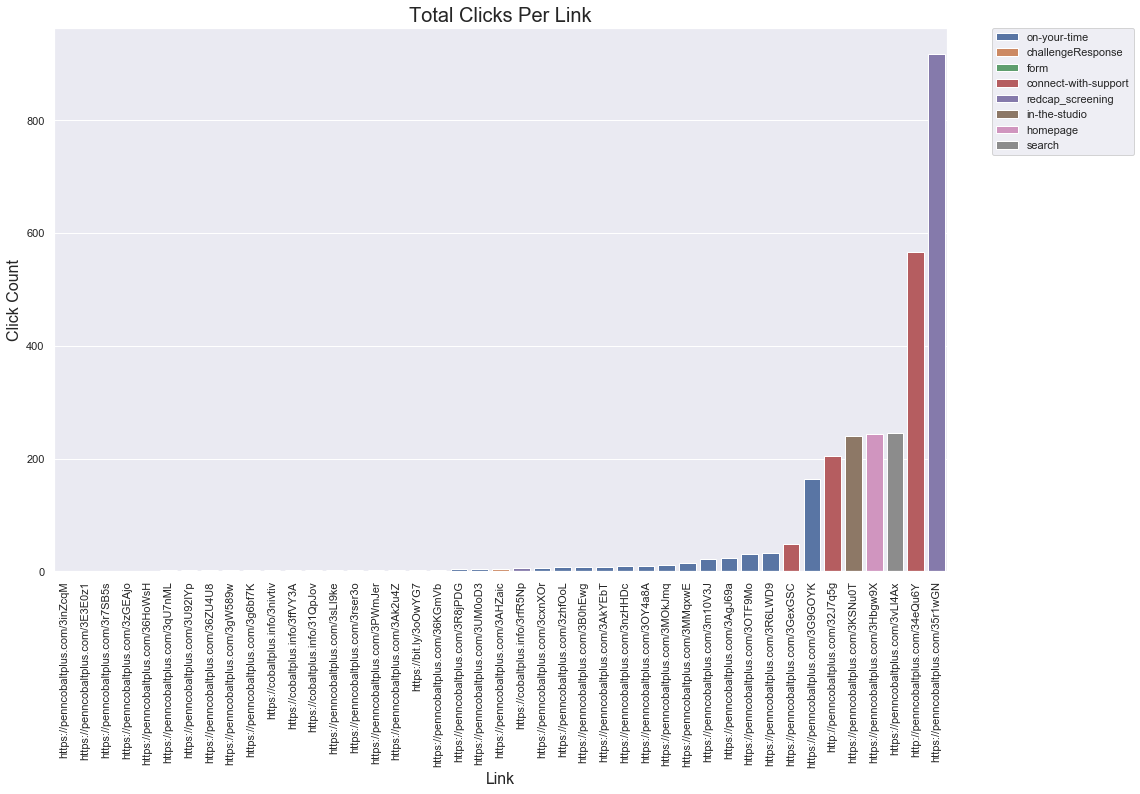

In [124]:
ax = sns.barplot(data=temp_data.reset_index(), x='index', y='clicks_for_all_time', hue='services', dodge=False)
ax.figure.set_size_inches(16,10)
ax.set_xlabel('Link', fontsize=16)
ax.set_ylabel('Click Count', fontsize=16)
ax.set_title('Total Clicks Per Link', fontsize=20)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [523]:
# Cobalt pages
bitly_cobalt_top = bitly_data_top[bitly_data_top['title']=='Cobalt']

# content 
on_your_time = bitly_data_top[bitly_data_top['long_url'].str.contains('on-your-time')].copy()
content_keys = on_your_time['long_url'].apply(lambda x: x.split('?')[0].split('/')[-1]).copy()
on_your_time['content_key'] = content_keys
on_your_time['date_norm'] = STUDY_END_DATE - on_your_time['date_created']
on_your_time['clicks_for_all_time_norm'] = (on_your_time['clicks_for_all_time']/on_your_time['date_norm'].apply(lambda x: x.days))*30

bitly_use_cols = ['long_url','date_norm','clicks_for_all_time','clicks_for_all_time_norm','content_key']
content_use_cols = ['content_type_id','title','description','url','content_id']
on_your_time = on_your_time[bitly_use_cols].merge(content[content_use_cols],left_on='content_key',right_on='content_id', how='inner')
on_your_time['content_type_color'] = on_your_time['content_type_id'].map(content_type_color_dict)

content_title_dict = dict(on_your_time[['content_key','title']].values)
content_type_dict = dict(on_your_time[['content_key','content_type_id']].values)

# appointments
connect_with_support = bitly_data_top[bitly_data_top['long_url'].str.contains('connect-with-support')]

# groups
in_the_studio = bitly_data_top[bitly_data_top['long_url'].str.contains('in-the-studio')]

# homepage
homepage = bitly_data_top[bitly_data_top['long_url'].str.contains('https://www.penncobalt.com/\?')]

In [524]:
print('Total Clicks:', bitly_cobalt_top['clicks_for_all_time'].sum())
print('Content Clicks: ',on_your_time['clicks_for_all_time'].sum())
print('Appointment Clicks: ',connect_with_support['clicks_for_all_time'].sum())
print('Group Clicks: ',in_the_studio['clicks_for_all_time'].sum())
print('Homepage Clicks: ',homepage['clicks_for_all_time'].sum())

Total Clicks: 1691
Content Clicks:  381
Appointment Clicks:  826
Group Clicks:  240
Homepage Clicks:  244


In [617]:
# Pie chart
def get_pie_chart(data, title, explode_str=''):
    def format_text(pct, counts):
        absolute = int(np.round(pct/100.*np.sum(counts)))
        return "{:d}\n({:.1f}%)".format(absolute,pct)
    
    labels = data.index
    pie_data = data.iloc[:,0]
    explode = [0 if item!=explode_str else 0.1 for item in data.index.values]

    fig, ax = plt.subplots(figsize=(8,8), facecolor='whitesmoke')
    ax.pie(pie_data, explode=explode, labels=labels, autopct=lambda pct: format_text(pct, pie_data), 
           textprops=dict(color="black",size=14), shadow=False, startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    fig.suptitle(title, fontsize=18)

    plt.show()

In [618]:
idx = ['Content Clicks','Appointment Clicks','Group Clicks','Homepage Clicks']
counts = [on_your_time['clicks_for_all_time'].sum(),connect_with_support['clicks_for_all_time'].sum(),
          in_the_studio['clicks_for_all_time'].sum(),homepage['clicks_for_all_time'].sum()]
pcts = [item/sum(counts) for item in counts]
click_totals = pd.DataFrame(zip(counts,pcts), index=idx, columns=['click_count','click_pct'])
click_totals

,click_count,click_pct
Content Clicks,381,0.2253
Appointment Clicks,826,0.4885
Group Clicks,240,0.1419
Homepage Clicks,244,0.1443


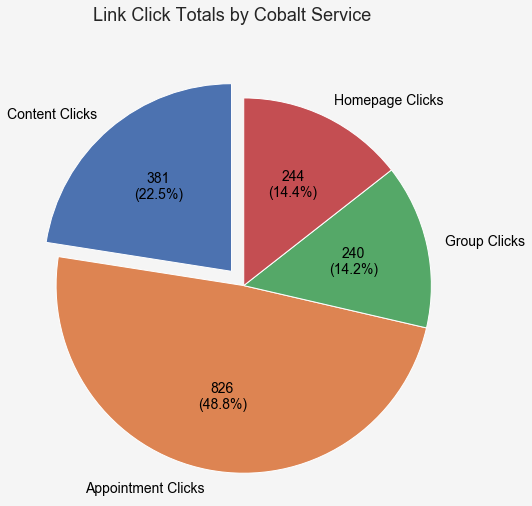

In [619]:
get_pie_chart(click_totals, 'Link Click Totals by Cobalt Service','Content Clicks')

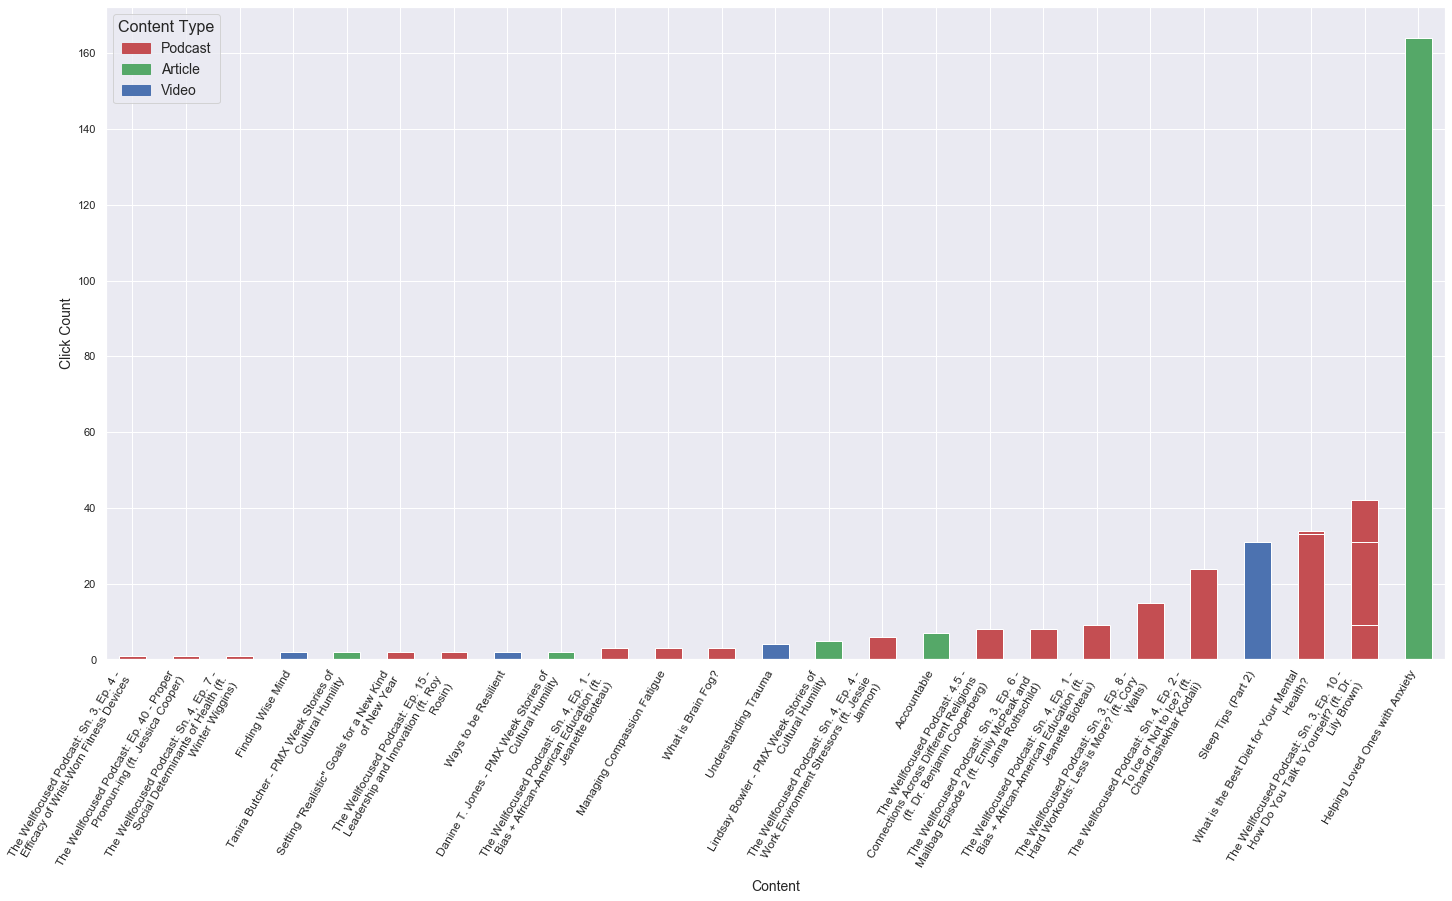

In [595]:
plot_data = on_your_time.set_index(['content_key','long_url'],drop=False)[['clicks_for_all_time']].unstack().droplevel(axis=1, level=0).fillna(0)
plot_data = plot_data.loc[plot_data.sum(axis=1).sort_values().index]
xlabels = [textwrap.fill(content_title_dict[item],40) for item in plot_data.index]
col_keys = [item.split('?')[0].split('/')[-1] for item in plot_data.columns]
bar_colors = [content_type_color_dict[content_type_dict[item]] for item in col_keys]

ax = plot_data.plot(figsize=(24,12),kind='bar',stacked=True,legend=None,color=bar_colors)
ax.set_xticklabels(xlabels,rotation=60,ha='right', fontsize=12)
ax.set_xlabel('Content', fontsize=14)
ax.set_ylabel('Click Count', fontsize=14)

red_patch = mpatches.Patch(color='r', label='Podcast')
green_patch = mpatches.Patch(color='g', label='Article')
blue_patch = mpatches.Patch(color='b', label='Video')

plt.legend(handles=[red_patch,green_patch,blue_patch],fontsize=14,title='Content Type',title_fontsize=16)

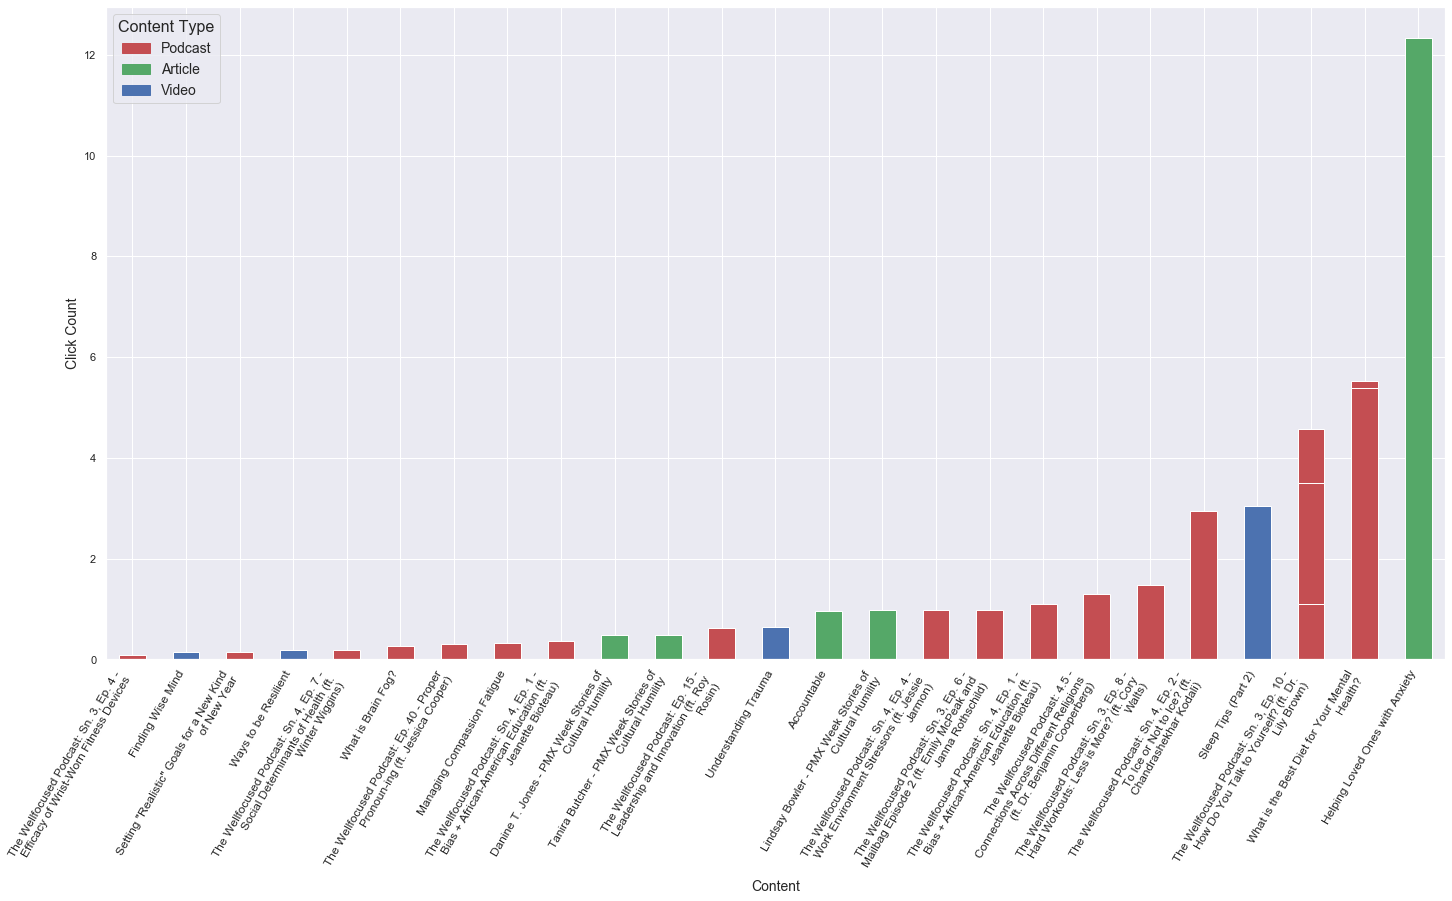

In [609]:
plot_data = on_your_time.set_index(['content_key','long_url'],drop=False)[['clicks_for_all_time_norm']].unstack().droplevel(axis=1, level=0).fillna(0)
plot_data = plot_data.loc[plot_data.sum(axis=1).sort_values().index]
xlabels = [textwrap.fill(content_title_dict[item],40) for item in plot_data.index]
col_keys = [item.split('?')[0].split('/')[-1] for item in plot_data.columns]
bar_colors = [content_type_color_dict[content_type_dict[item]] for item in col_keys]

ax = plot_data.plot(figsize=(24,12),kind='bar',stacked=True,legend=None,color=bar_colors)
ax.set_xticklabels(xlabels,rotation=60,ha='right', fontsize=12)
ax.set_xlabel('Content', fontsize=14)
ax.set_ylabel('Click Count', fontsize=14)

red_patch = mpatches.Patch(color='r', label='Podcast')
green_patch = mpatches.Patch(color='g', label='Article')
blue_patch = mpatches.Patch(color='b', label='Video')

plt.legend(handles=[red_patch,green_patch,blue_patch],fontsize=14,title='Content Type',title_fontsize=16)

In [ ]:
plot_data = on_your_time.set_index(['content_key','long_url'],drop=False)[['clicks_for_all_time_norm']].unstack()
plot_data = plot_data.loc[plot_data.sum(axis=1).sort_values().index]
ax = plot_data.plot(figsize=(16,8),kind='bar',stacked=True,legend=None,color='blue')

### Bitlinks - Working

In [183]:
# merge with content on bitly_data_top.long_url.split('/')[-1] and content.content_id
bitly_data_top.long_url.unique()

array(['https://www.penncobalt.com/on-your-time/bdf7f7f5-912f-4d8b-9329-f6d756f0be55',
       'https://www.penncobalt.com/on-your-time/e8fc416d-af4f-4871-8669-c133907cddae?utm_source=cobalt&utm_medium=month3&utm_campaign=oct+2022',
       'https://challengeresponse.apps.upenn.edu/challengeResponse/jsp/fast.do?fastStart=resetPassword&utm_source=penn&utm_medium=key&utm_campaign=password',
       'https://www.penncobalt.com/on-your-time/f7a6f530-cc51-4fad-9d62-b75aafbc9f52?utm_source=cobalt&utm_medium=monthly+3&utm_campaign=august+1',
       'https://www.penncobalt.com/on-your-time/c74c24e7-9cf3-4af5-a40e-a0e0fd1aaa8f?utm_source=cobalt&utm_medium=april+2022+popular+content&utm_campaign=april+2022+popular+content',
       'https://www.penncobalt.com/on-your-time/84ee5ddb-4acd-4d9c-bd80-37329feb1cea?utm_source=cobalt&utm_medium=month3&utm_campaign=april+2022+popular+content',
       'https://www.penncobalt.com/on-your-time/5ddfe9c0-e69a-4bfb-9388-29c4203605ac',
       'https://upenn.co1.qua

In [159]:
[item for item in bitly_data.long_url.sort_values().unique() for substring in ['on-your-time', 'connect-with-support'] if substring in item]

['https://www.penncobalt.com/connect-with-support?supportRoleId=CLINICIAN&immediateAccess=false&track=true&accountSourceId=PENN_KEY_SSO&utm_source=cobalt&utm_medium=therapist&utm_campaign=therapist',
 'https://www.penncobalt.com/connect-with-support?supportRoleId=COACH&immediateAccess=false&track=true&accountSourceId=PENN_KEY_SSO',
 'https://www.penncobalt.com/connect-with-support?supportRoleId=COACH&immediateAccess=false&track=true&accountSourceId=PENN_KEY_SSO&utm_source=cobalt&utm_medium=coach&utm_campaign=coach',
 'https://www.penncobalt.com/connect-with-support?supportRoleId=COACH&immediateAccess=false&track=true&accountSourceId=PENN_KEY_SSO&utm_source=cobalt&utm_medium=page&utm_campaign=jan+2022',
 'https://www.penncobalt.com/connect-with-support?supportRoleId=PSYCHIATRIST&immediateAccess=false&track=true&accountSourceId=PENN_KEY_SSO&utm_source=cobalt&utm_medium=page&utm_campaign=jan+2022',
 'https://www.penncobalt.com/connect-with-support?supportRoleId=PSYCHIATRIST&immediateAcces

In [152]:
[item.split('?') for item in bitly_data.long_url.sort_values().unique()]

[['https://challengeresponse.apps.upenn.edu/challengeResponse/jsp/fast.do',
  'fastStart=forgotMyUsername&utm_source=penn&utm_medium=pennkey&utm_campaign=username'],
 ['https://challengeresponse.apps.upenn.edu/challengeResponse/jsp/fast.do',
  'fastStart=resetPassword&utm_source=penn&utm_medium=key&utm_campaign=password'],
 ['https://redcap.link/cobaltRCT',
  'utm_source=redcap&utm_medium=screening&utm_campaign=survey'],
 ['https://upenn.box.com/s/mxlafo5echcubp30ru8kame54j0cc3h3',
  'utm_source=visa+&utm_medium=clincard&utm_campaign=faq'],
 ['https://upenn.co1.qualtrics.com/jfe/form/SV_8ew9E5HybDBSG46',
  'utm_source=qualtrics&utm_medium=informed+consent&utm_campaign=informed+consent'],
 ['https://upenn.co1.qualtrics.com/jfe/form/SV_cC6uLGeaP1g7hXM',
  'utm_source=qualtrics&utm_medium=faq&utm_campaign=faq'],
 ['https://www.penncobalt.com/',
  'utm_source=cobalt&utm_medium=homepage&utm_campaign=homepage'],
 ['https://www.penncobalt.com/connect-with-support',
  'supportRoleId=CLINICIAN&

In [173]:
print(bitly_data_top.clicks_for_all_time.sum())
bitly_data_top

2871


,title,long_url,date_created,date_range_start,date_range_end,created_start,created_end,start_end,clicks_for_all_time
https://penncobaltplus.com/3inZcqM,Cobalt,https://www.penncobalt.com/on-your-time/bdf7f7...,2022-11-28,2022-11-28,2022-12-05,0 days,7 days,7 days,1
https://penncobaltplus.com/3E3E0z1,Cobalt,https://www.penncobalt.com/on-your-time/e8fc41...,2022-09-30,2022-09-30,2022-11-28,0 days,59 days,59 days,1
https://penncobaltplus.com/3r7SB5s,PennKey Recovery Service,https://challengeresponse.apps.upenn.edu/chall...,2022-01-28,2022-05-20,2022-07-18,112 days,171 days,59 days,1
https://penncobaltplus.com/3zGEAjo,Cobalt,https://www.penncobalt.com/on-your-time/f7a6f5...,2022-07-29,2022-08-12,2022-10-10,14 days,73 days,59 days,1
https://penncobaltplus.com/36HoWsH,Cobalt,https://www.penncobalt.com/on-your-time/c74c24...,2022-04-01,2022-04-05,2022-06-03,4 days,63 days,59 days,1
https://penncobaltplus.com/3qU7nML,Cobalt,https://www.penncobalt.com/on-your-time/84ee5d...,2022-04-01,2022-04-05,2022-06-03,4 days,63 days,59 days,2
https://penncobaltplus.com/3U92lYp,Cobalt,https://www.penncobalt.com/on-your-time/5ddfe9...,2022-11-28,2022-11-28,2022-12-05,0 days,7 days,7 days,2
https://penncobaltplus.com/36ZU4U8,Qualtrics Survey | Qualtrics Experience Manage...,https://upenn.co1.qualtrics.com/jfe/form/SV_8e...,2022-04-07,2022-04-05,2022-06-03,-2 days,57 days,59 days,2
https://penncobaltplus.com/3gW589w,Cobalt,https://www.penncobalt.com/on-your-time/d0d93f...,2022-10-31,2022-11-28,2022-12-05,28 days,35 days,7 days,2
https://penncobaltplus.com/3g6bf7K,Cobalt,https://www.penncobalt.com/on-your-time/d7228f...,2022-01-28,2022-01-28,2022-03-28,0 days,59 days,59 days,2


In [ ]:
temp_data = bitly_data_top[['clicks_for_all_time','created_start','created_end','start_end']]
temp_data['clicks_created_start'] = temp_data['clicks_for_all_time']/temp_data['created_start']
temp_data['clicks_created_end'] = temp_data['clicks_for_all_time']/temp_data['created_end']
temp_data['clicks_start_end'] = temp_data['clicks_for_all_time']/temp_data['start_end']
temp_data['did_exist_at start'] = temp_data['date_created'].apply(lambda x: 1 if x['date_range_start']>x['date_created'] else 0)
temp_data['did_exist'] = temp_data['date_created'].apply(lambda x: 1 if x['date_range_end']<x['date_created'] else 0)

In [ ]:
bitlink_click_data['year'] = bitlink_click_data['date_created'].dt.year
bitlink_click_data['month'] = bitlink_click_data['date_created'].dt.month
bitlink_click_data['day'] = bitlink_click_data['date_created'].dt.day
bitlink_click_data['hour'] = bitlink_click_data['date_created'].dt.hour
bitlink_click_data['weekofyear'] = bitlink_click_data['date_created'].dt.weekofyear
bitlink_click_data['dayofyear'] = bitlink_click_data['date_created'].dt.dayofyear
bitlink_click_data['dayofweek'] = bitlink_click_data['date_created'].dt.dayofweek

# hmmm...
bitlink_click_data.groupby(['long_url','year','month','day'])[['clicks_for_all_time']].count()

In [ ]:
usecols = ['title','long_url','date_created','date_range_start','date_range_end','created_start','created_end','start_end','clicks_for_all_time']

bitly_link_clicks = data.copy()
bitly_link_clicks.index = bitly_link_clicks.index.rename(name='bitlink')
bitly_link_clicks['bitlink_code'] = [item.split('/')[-1] for item in bitly_link_clicks.index]
bitly_link_clicks = bitly_link_clicks[usecols]

four_split = [(idx,row['long_url'].split('/')) for idx,row in bitly_link_clicks.iterrows() if len(row['long_url'].split('/'))==4]
five_split = [(idx,row['long_url'].split('/')) for idx,row in bitly_link_clicks.iterrows() if len(row['long_url'].split('/'))==5]
six_split = [(idx,row['long_url'].split('/')) for idx,row in bitly_link_clicks.iterrows() if len(row['long_url'].split('/'))==6]

In [940]:
four_split_dict = dict()

for item in four_split:
    four_split_idx = item[0]
    four_split_domain = ['domain='+item[1][2]]
    
    four_split_temp = item[1][3].split('?')
    four_split_service = ['service='+item[0]]
    four_split_data = four_split_temp[1].split('&')

    four_split_row = four_split_domain + four_split_service + four_split_data
    four_split_dict[four_split_idx] = [item.split('=') for item in four_split_row]

In [941]:
five_split_dict = dict()

for item in five_split:
    five_split_idx = item[0]
    five_split_domain = ['domain='+item[1][2]]
    five_split_service = ['service='+item[1][3]]
    five_split_data = item[1][4].split('?')
    if len(five_split_data) == 1:
        five_split_data = ['key='+five_split_data[0]]
    else:
        five_split_data = ['key='+five_split_data[0]] + five_split_data[1].split('&')

    five_split_row = five_split_domain + five_split_service + five_split_data
    five_split_dict[five_split_idx] = [item.split('=') for item in five_split_row]

In [902]:
six_split_dict = dict()

for item in six_split:
    six_split_idx = item[0]
    six_split_domain = ['domain='+item[1][2]]
    six_split_service = ['service='+item[1][3]]
    six_split_data = item[1][5].split('?')
    if len(six_split_data) == 1:
        six_split_data = ['key='+six_split_data[0]]
    else:
        six_split_data = ['key='+six_split_data[0]] + six_split_data[1].split('&')

    six_split_row = six_split_domain + six_split_service + six_split_data
    six_split_dict[six_split_idx] = [item.split('=') for item in six_split_row]

In [903]:
print(len(four_split_dict))
print(len(five_split_dict))
print(len(six_split_dict))

10
29
4


## Unused / Deprecated Code

In [ ]:
"""

cobalt_primary = account_email.merge(enrollment[['participant_id','primary_email']], how='inner', left_on='email_address', right_on='primary_email')
cobalt_primary = cobalt_primary.rename(columns={'primary_email':'participant_email'})
cobalt_secondary = account_email.merge(enrollment[['participant_id','secondary_email']], how='inner', left_on='email_address', right_on='secondary_email')
cobalt_secondary = cobalt_secondary.rename(columns={'secondary_email':'participant_email'})
cobalt_plus = pd.concat([cobalt_primary,cobalt_secondary])


cobalt_primary[cobalt_primary['account_id']=='d19a1181-484a-4f7b-aad2-3fc25bed0bbc']
enrollment[enrollment['participant_id'].isin(['1000774964','1000776739'])]


# accounts: new and existing
# appointments: after 01/31/2022

use_cols = ['account_id','account_source_id'] + enrollment_email.columns.to_list()
study_acct_date = study_acct[study_acct['created']>= pd.to_datetime('01/01/2022').tz_localize(tz=COBALT_TZ)].sort_values('created')
study_appt_date = study_appt[study_appt['created']>= pd.to_datetime('01/01/2022').tz_localize(tz=COBALT_TZ)].sort_values('created')
study_acctAppt_date = study_acct_date[study_acct_date['account_id'].isin(study_appt['account_id'])]


"""

In [ ]:
"""

print(len(screening_session.created_by_account_id.unique()))
print(len(screening_session[screening_session['completed']==True]))
print(len(screening_session_screening[screening_session_screening['completed']==True]))
screening_session.groupby(['completed','skipped','crisis_indicated'])[['screening_session_id']].count()

"""

In [ ]:
"""

screen_merged_target = screen_target.merge(screen_created,
                                           how='inner',
                                           on='target_account_id',
                                           suffixes=('_target','_created'),
                                           indicator='id_source')
screen_merged_created = screen_target.merge(screen_created,
                                           how='inner',
                                           on='target_account_id',
                                           suffixes=('_target','_created'),
                                           indicator='id_source')

"""

In [ ]:
"""

# Merging using 'created_by_account_id' instead of "target_account_id"
screen_created = screening_data_master.merge(study_acct[['account_id','arm']], 
                                             how='inner', 
                                             left_on='created_by_account_id', 
                                             right_on='account_id', 
                                             indicator='id_source')

screen_created_plot_data = screen_created.groupby(['screening_name','screening_score'])[['screening_session_screening_id']].count()
screen_created_plot_data = screen_created_plot_data.unstack().fillna(0).transpose()
screen_created_plot_data = screen_created_plot_data.droplevel(axis=0,level=0)

screen_created_plot_data.index = screen_created_plot_data.index.rename('Score')
screen_created_plot_data.columns = screen_created_plot_data.columns.rename('Screening')

# Display data
print('Total:',screen_target_plot_data['WHO-5'].sum())
print(len(screen_created_plot_data))
print(len(screen_created_plot_data.columns))
screen_created_plot_data.head()

"""

In [ ]:
"""

# OUTDATED
# Create dictionary for PHQ-9 and GAD-7
screening_id_dict = dict(screening[screening['name'].isin(['WHO-5','PHQ-9','GAD-7'])][['name','active_screening_version_id']].values)
screening_name_dict = {v:k for k,v in screening_id_dict.items()}

# Reformat screening session screening and scores so they are useable
screening_scores = screening_session_screening[screening_session_screening['screening_version_id'].isin(screening_id_dict.values())].copy()
screening_scores['screening_name'] = screening_scores['screening_version_id'].map(screening_name_dict)
screening_scores['screening_score'] = screening_scores['score'].apply(lambda x: x['overallScore'])

# Merge screening_session and screening_session_screening data to make useable dataset
screening_data_master = screening_scores.merge(screening_session,how='inner',on='screening_session_id',
                                               suffixes=('_screening','_session'),indicator='source')

"""

In [ ]:
"""

[item for item in ax.get_children() if type(item)==matplotlib.patches.Rectangle]

"""